In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import keras
import tensorflow as tf
import keras.backend as K

Using TensorFlow backend.


In [3]:
from keras import layers

In [4]:
model=keras.models.load_model('task2.h5')

In [5]:
ls=model.layers

In [6]:
for l in ls:
    print(l.name)

input_image
conv3x3_hl1
BatchNormalization_hl2
MaxPooling2D_hl3
conv3x3_hl4
BatchNormalization_hl5
flatten_1
Dense_cl1
Dense_ln1
Dense_ang1
Dense_th1
output_cl
output_ln
output_ang
output_th


In [7]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        (None, 28, 28, 3)    0                                            
__________________________________________________________________________________________________
conv3x3_hl1 (Conv2D)            (None, 26, 26, 32)   896         input_image[0][0]                
__________________________________________________________________________________________________
BatchNormalization_hl2 (BatchNo (None, 26, 26, 32)   128         conv3x3_hl1[0][0]                
__________________________________________________________________________________________________
MaxPooling2D_hl3 (MaxPooling2D) (None, 13, 13, 32)   0           BatchNormalization_hl2[0][0]     
__________________________________________________________________________________________________
conv3x3_hl

In [8]:
X=np.load('data/images.npy')
# Y=np.load('data/labels.npy')
# color=np.load('data/color.npy')
# length=np.load('data/length.npy')
# angle=np.load('data/angle.npy')
# thick=np.load('data/thick.npy')

In [9]:
def show_images(x):
    fig, axs = plt.subplots(2,3, figsize=(8,8))
    axs = axs.ravel()
    for i in range(6):
        axs[i].imshow(x[i])
        axs[i].set_title(str(i))

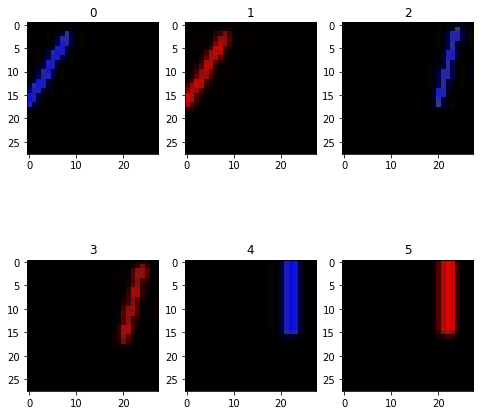

In [10]:
show_images(X[2000:2006])

In [11]:
x=X[2000:2006]

In [12]:
def print_filter(x,n,savename):
    fig=plt.figure(figsize=(32, 32))
    columns = 8
    rows = 4
    for i in range(0, columns*rows):
        fig.add_subplot(rows, columns, i+1)
        plt.imshow(x[:,:,i])
    plt.savefig(savename)
    plt.show()
    
    

In [13]:
def getNsave(layer_name,model,data):
    out=model.input
    for l in model.layers[1:]:
        out = l (out)
        if l.name==layer_name:
            break
    intermediate_layer_model = keras.models.Model(inputs=model.input,
                                 outputs=out)
    intermediate = intermediate_layer_model.predict(data)
    intermediate_layer_model.summary()
    for i in range(len(data)):
        print('------------',i,'------------')
        print_filter(intermediate[i],32,'output/'+str(i)+'th_imageActivation_'+layer_name)
    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     (None, 28, 28, 3)         0         
_________________________________________________________________
conv3x3_hl1 (Conv2D)         (None, 26, 26, 32)        896       
Total params: 896
Trainable params: 896
Non-trainable params: 0
_________________________________________________________________
------------ 0 ------------


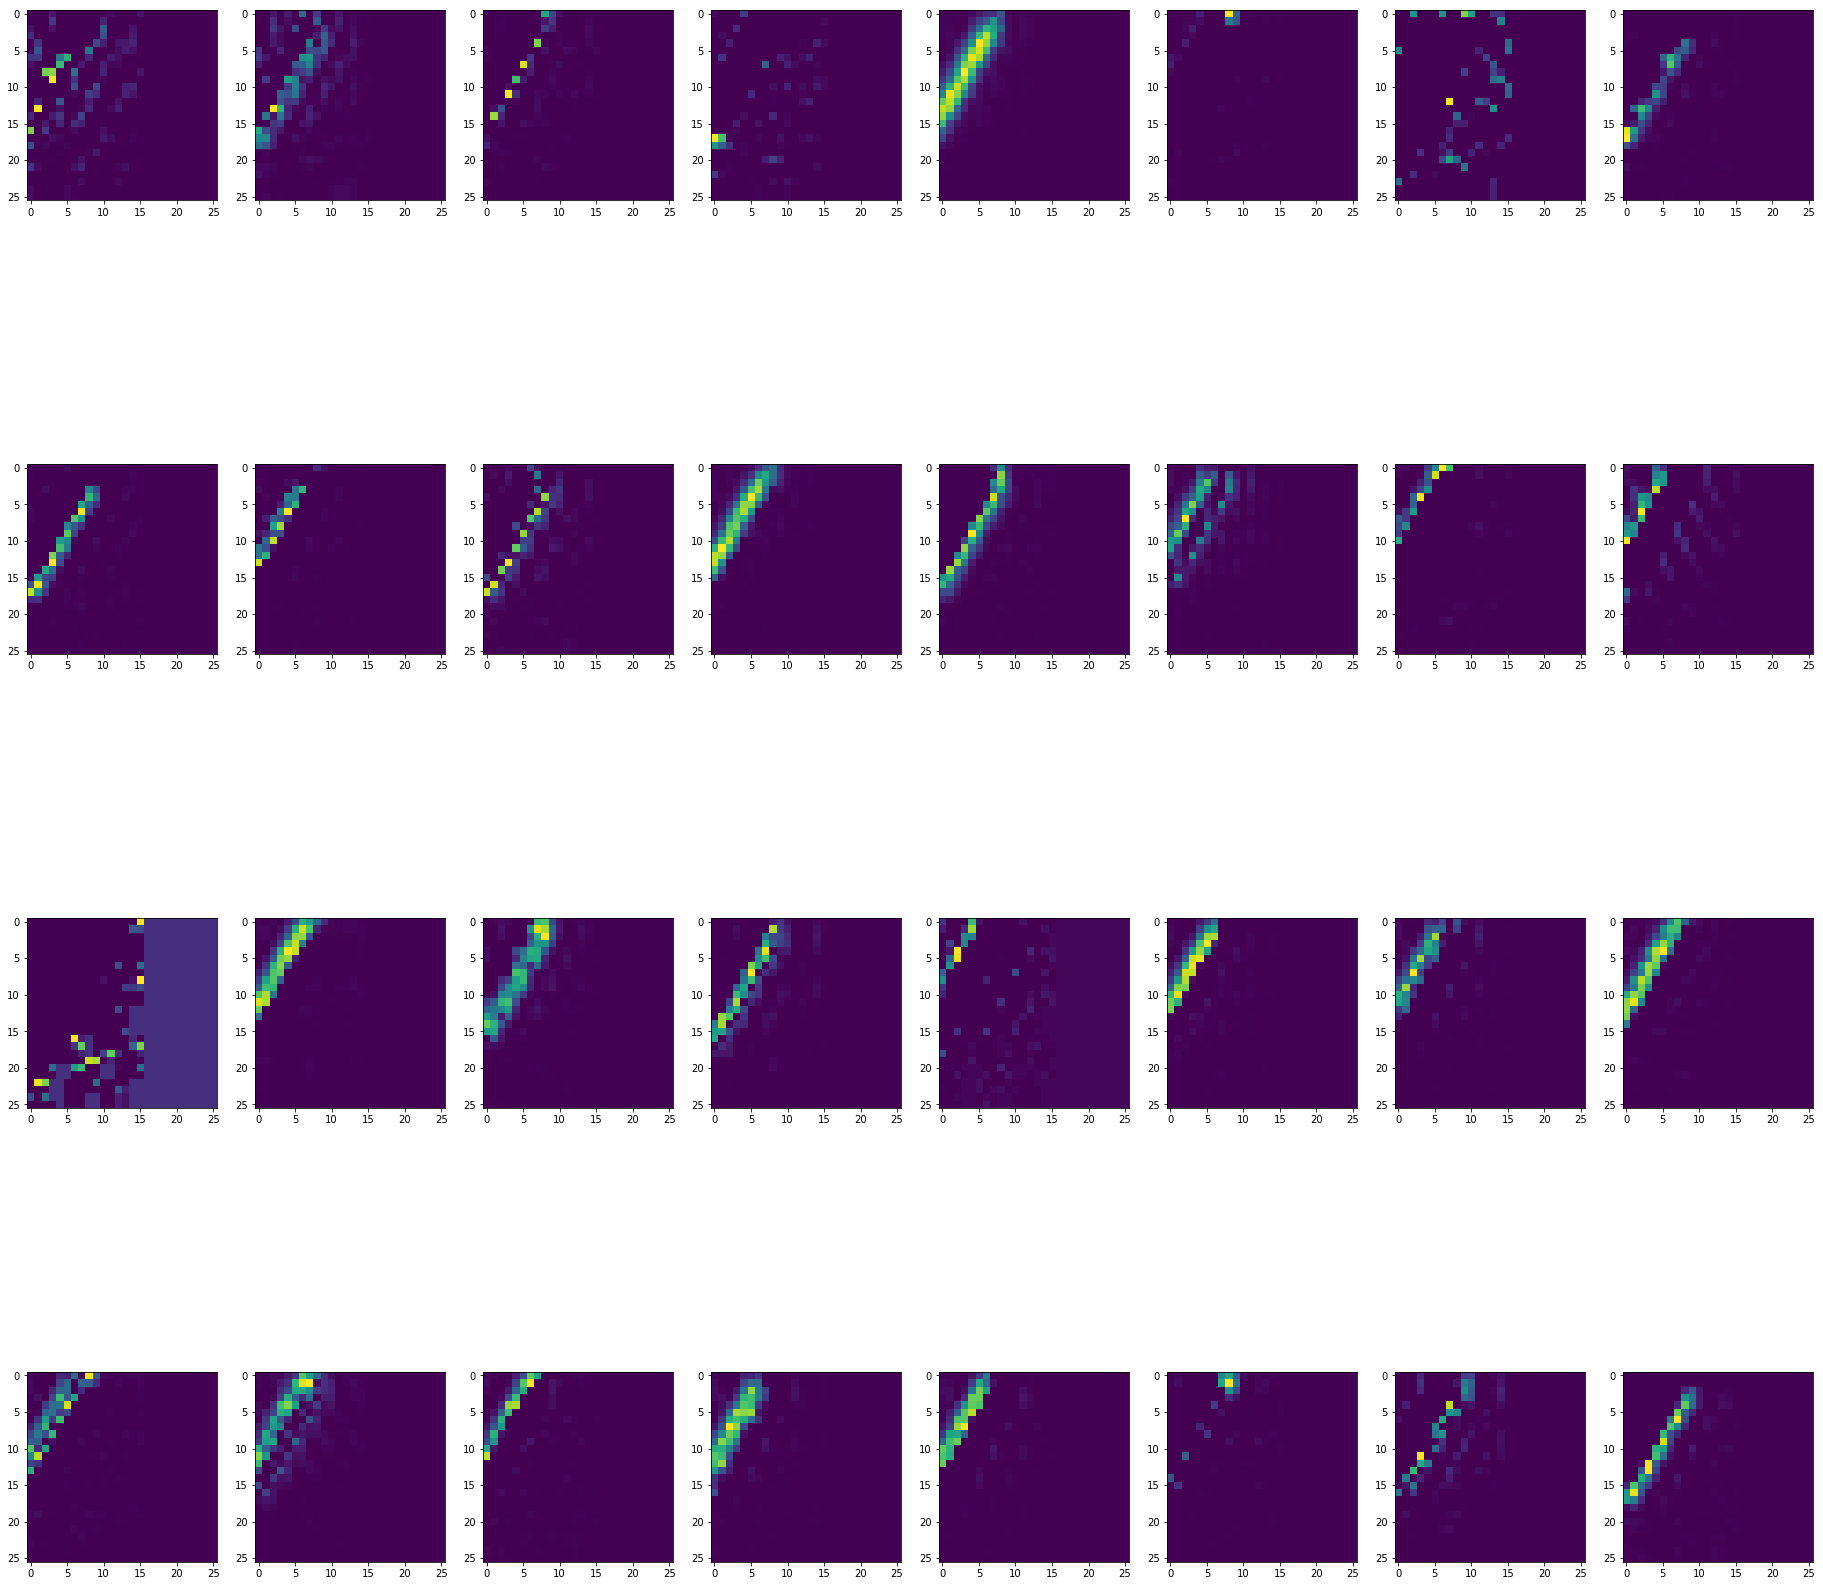

------------ 1 ------------


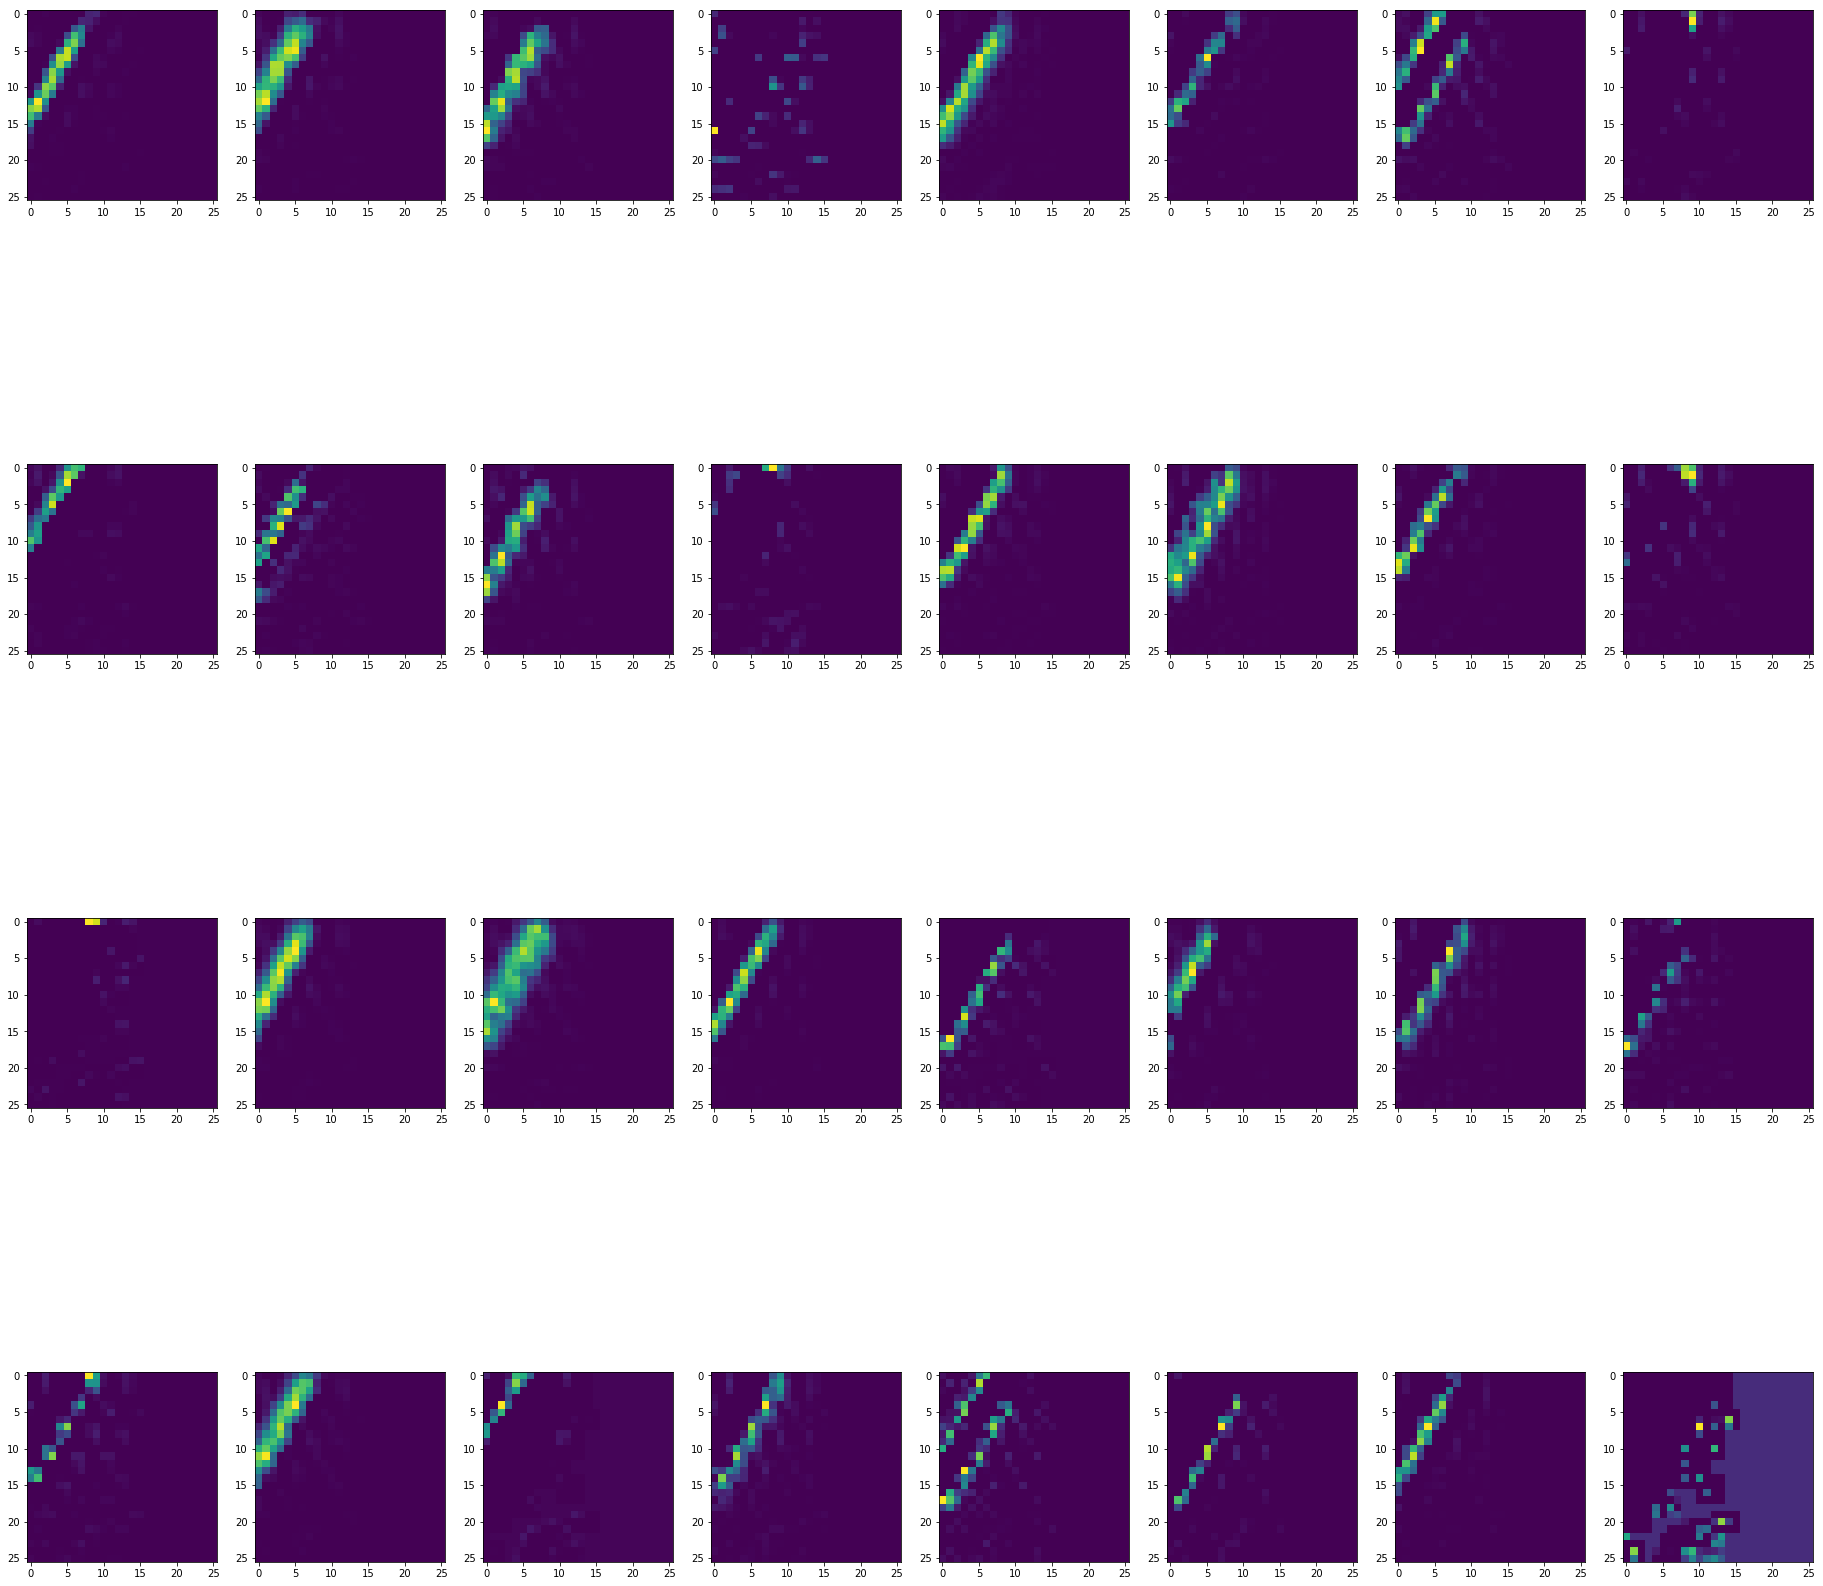

------------ 2 ------------


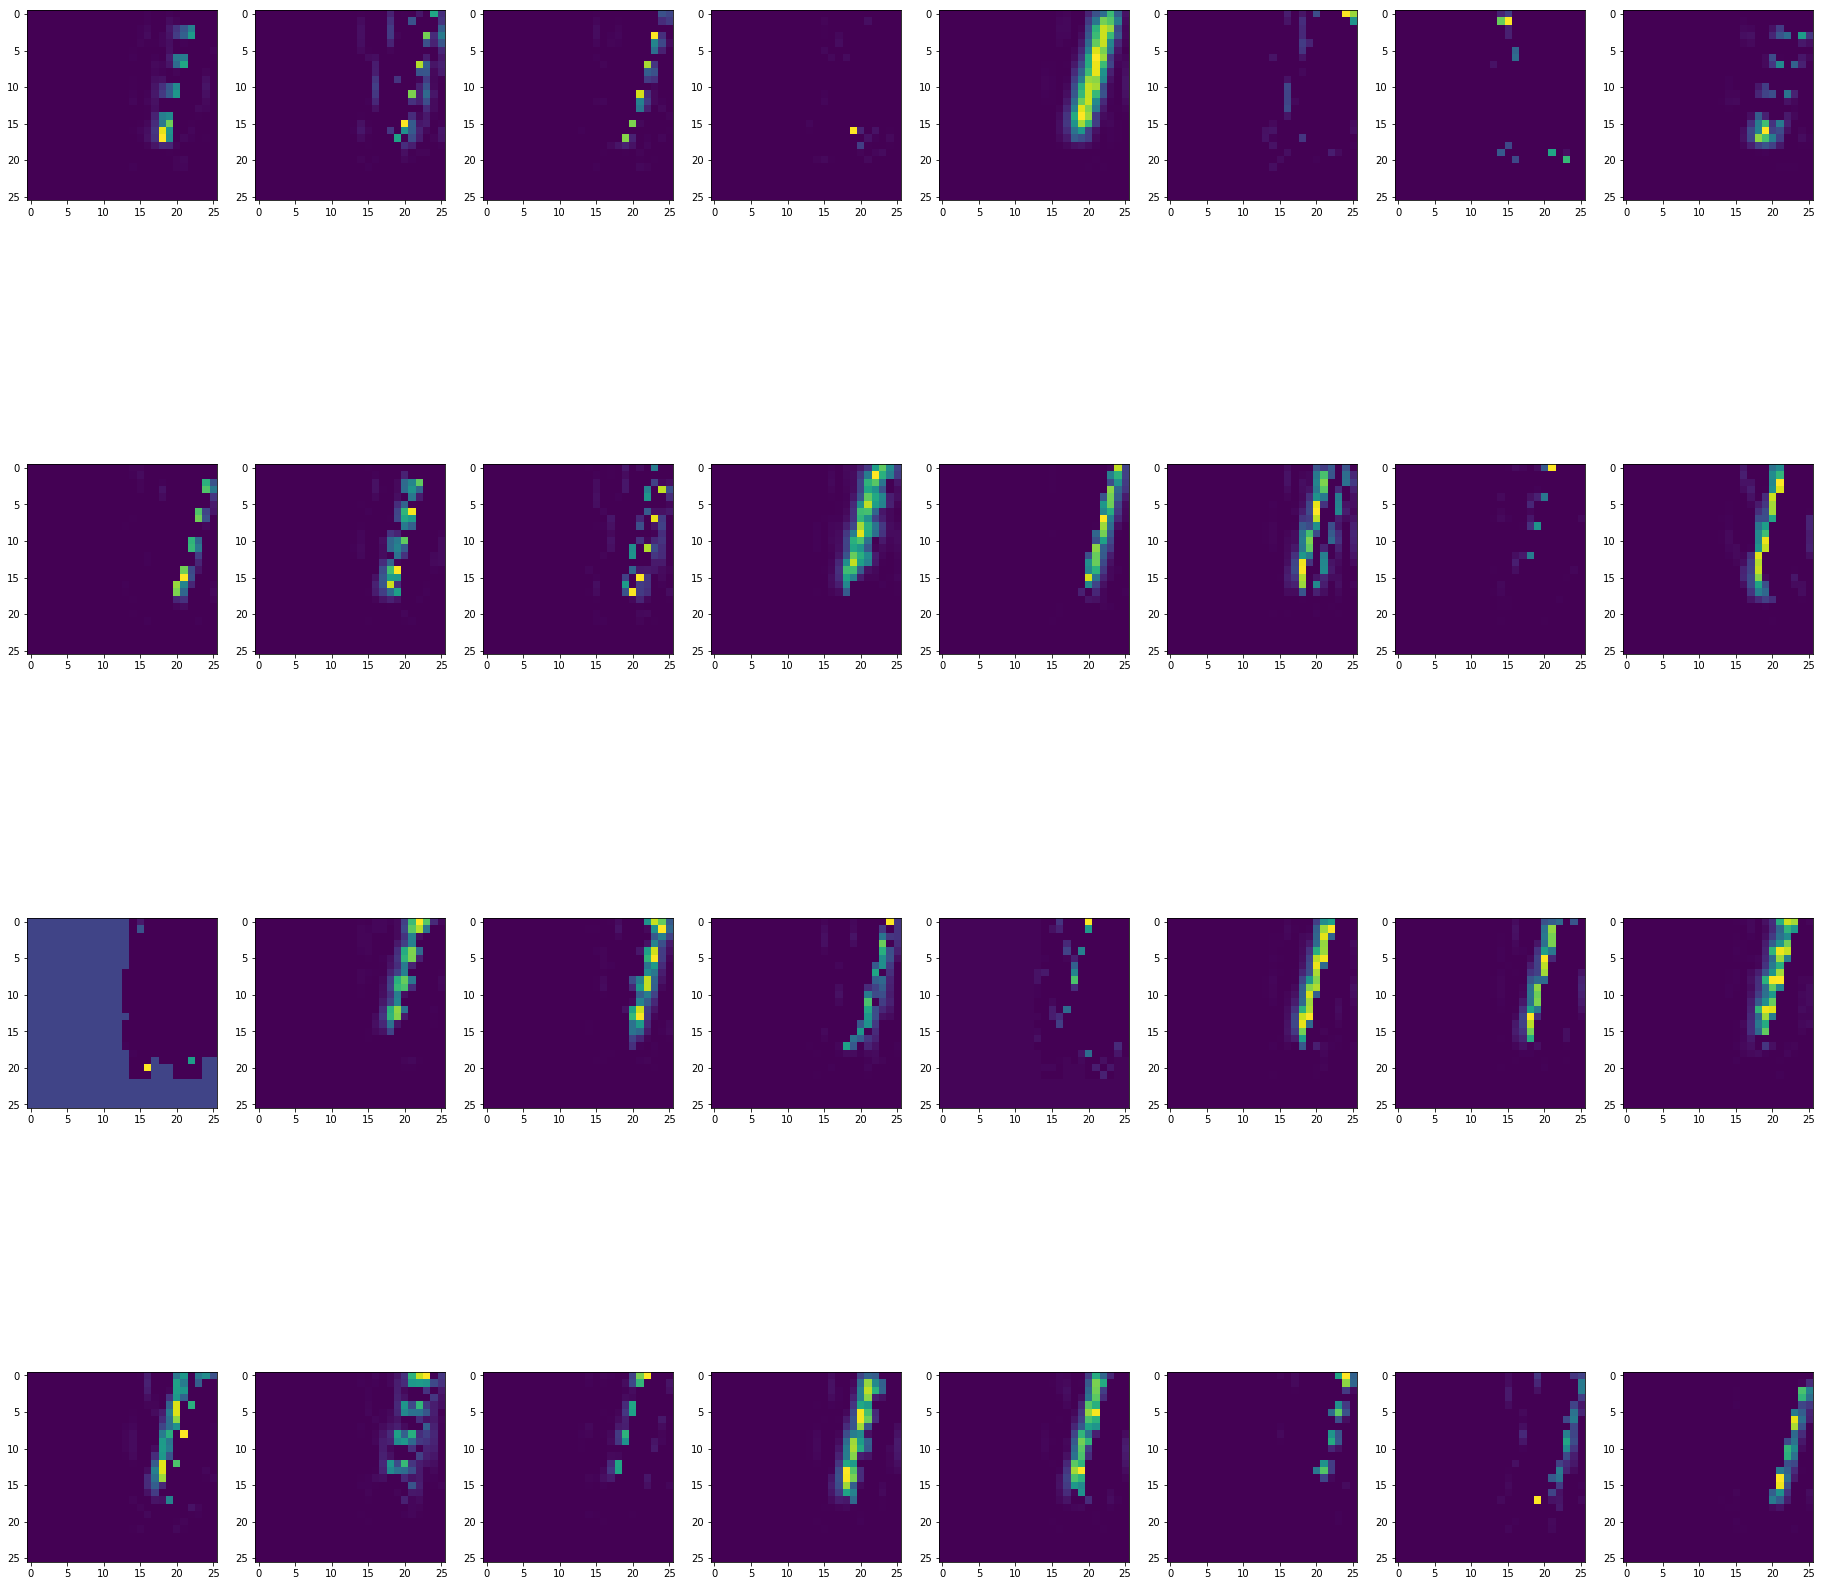

------------ 3 ------------


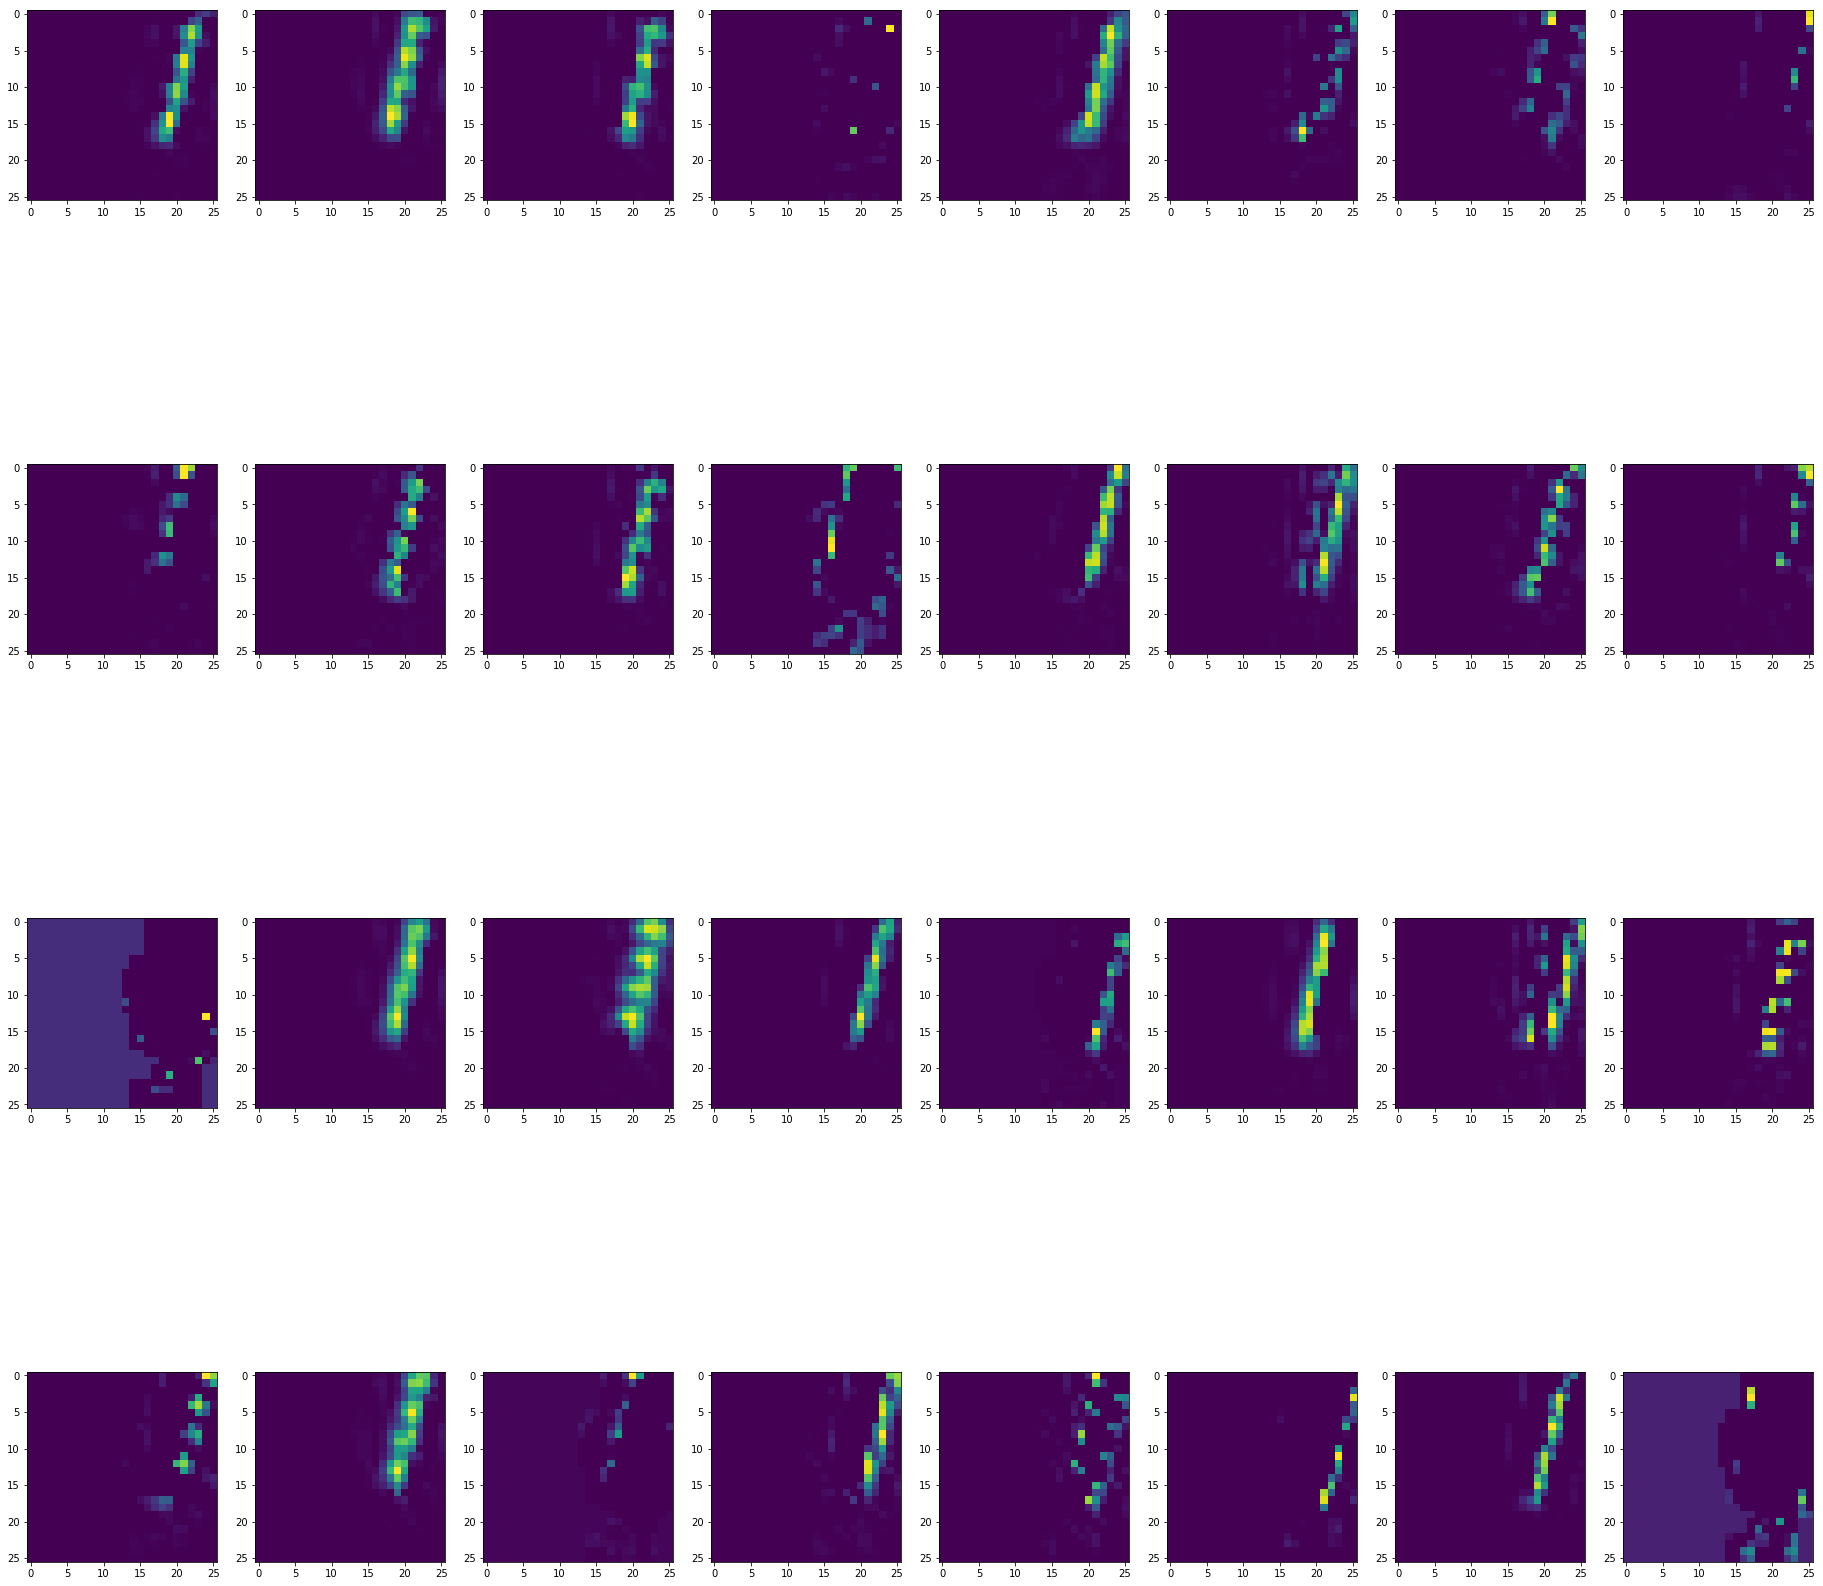

------------ 4 ------------


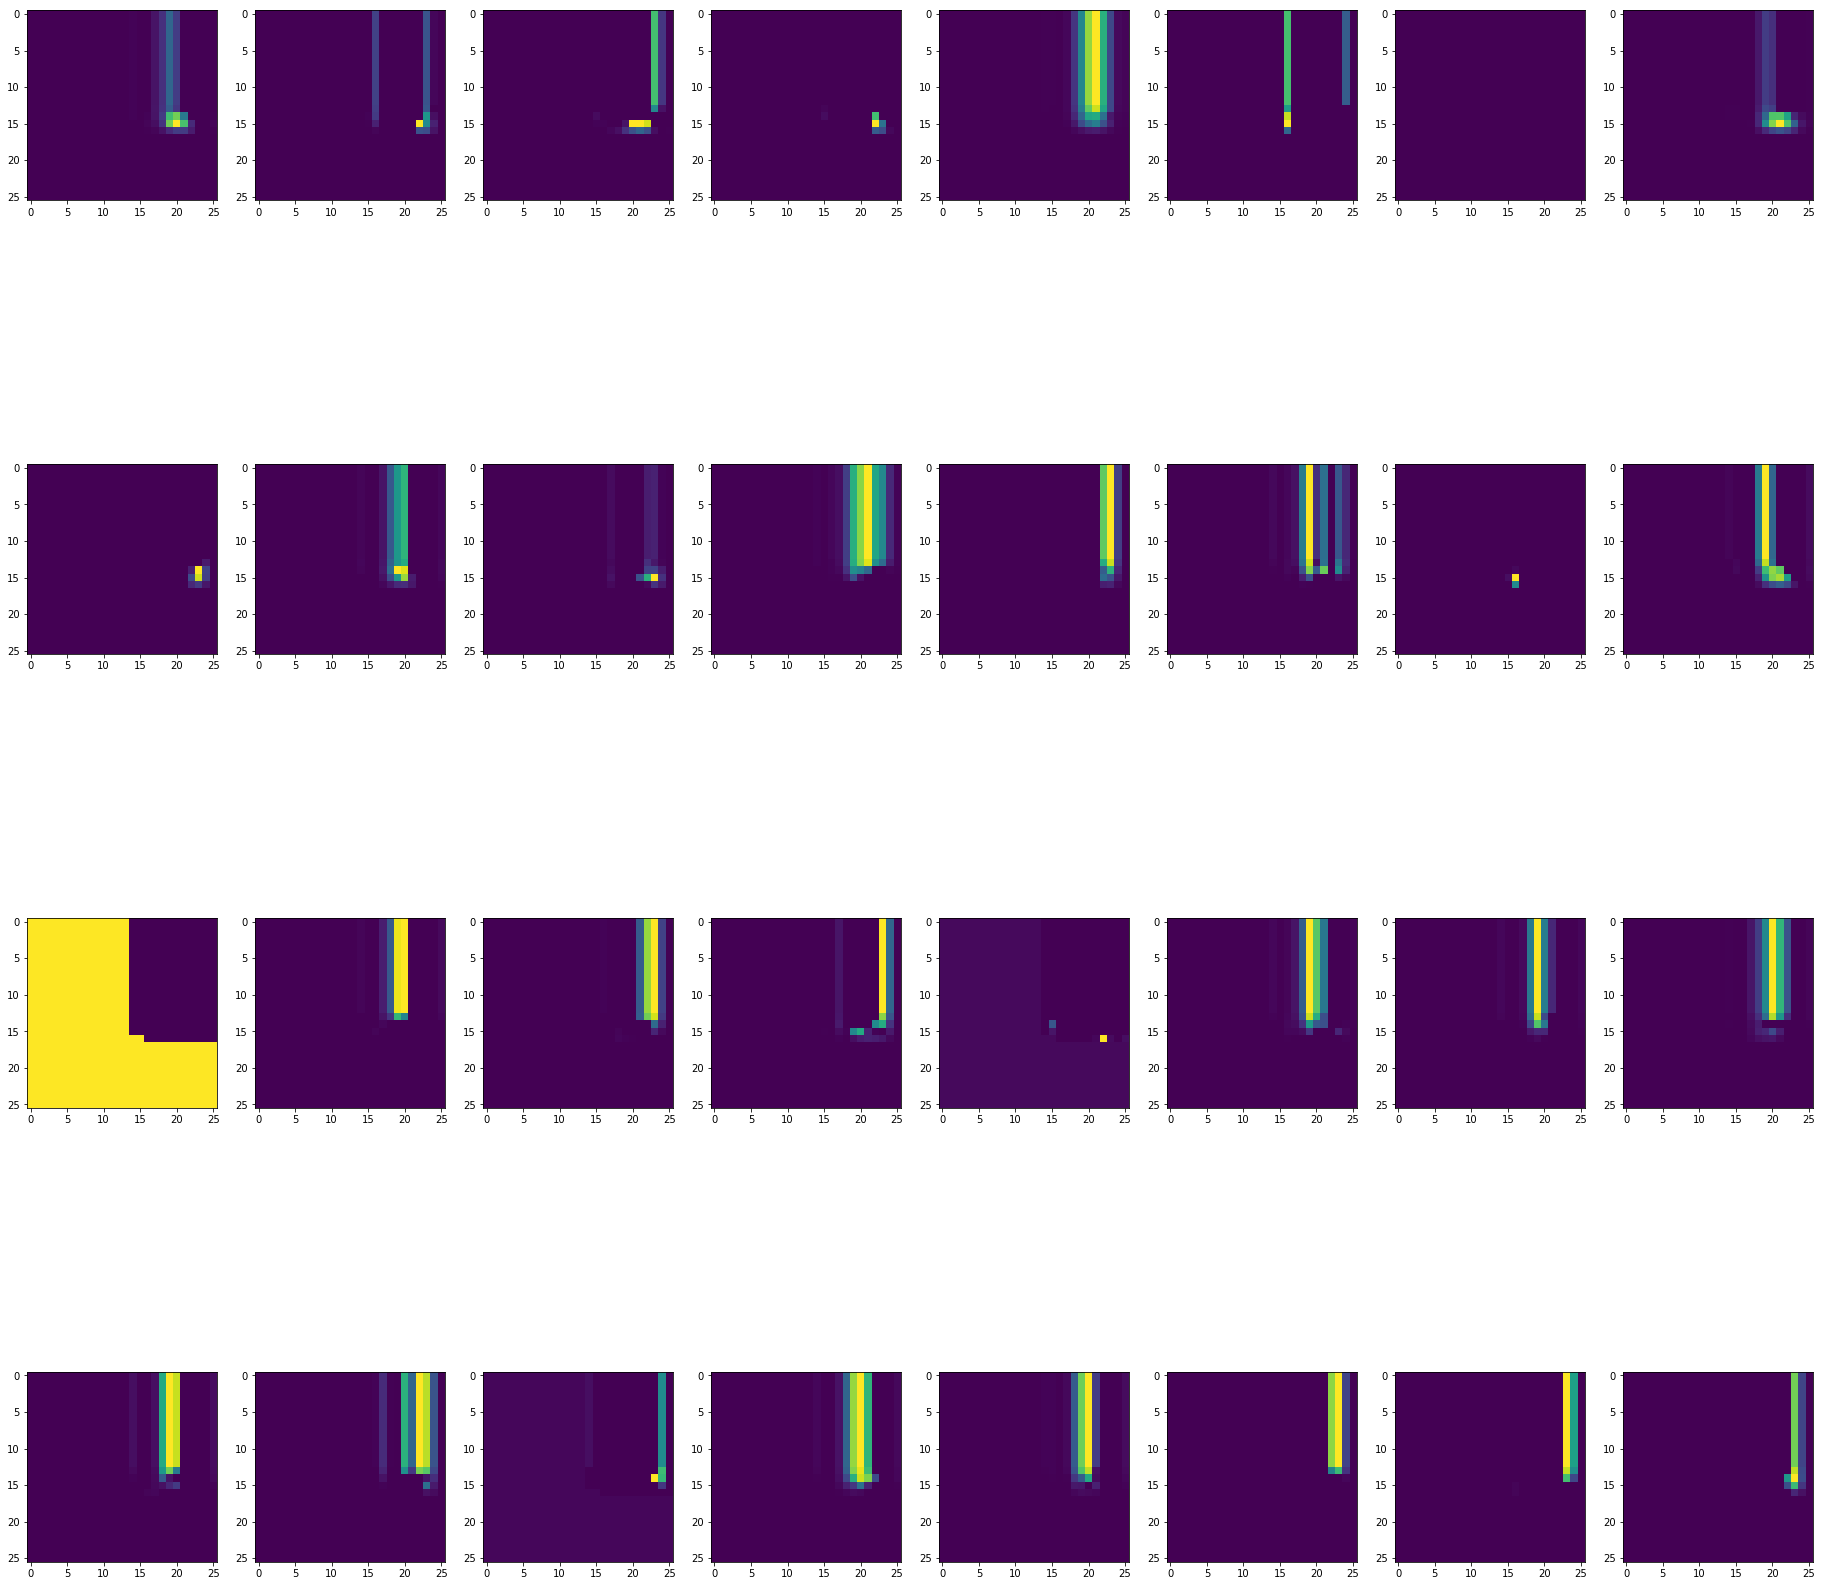

------------ 5 ------------


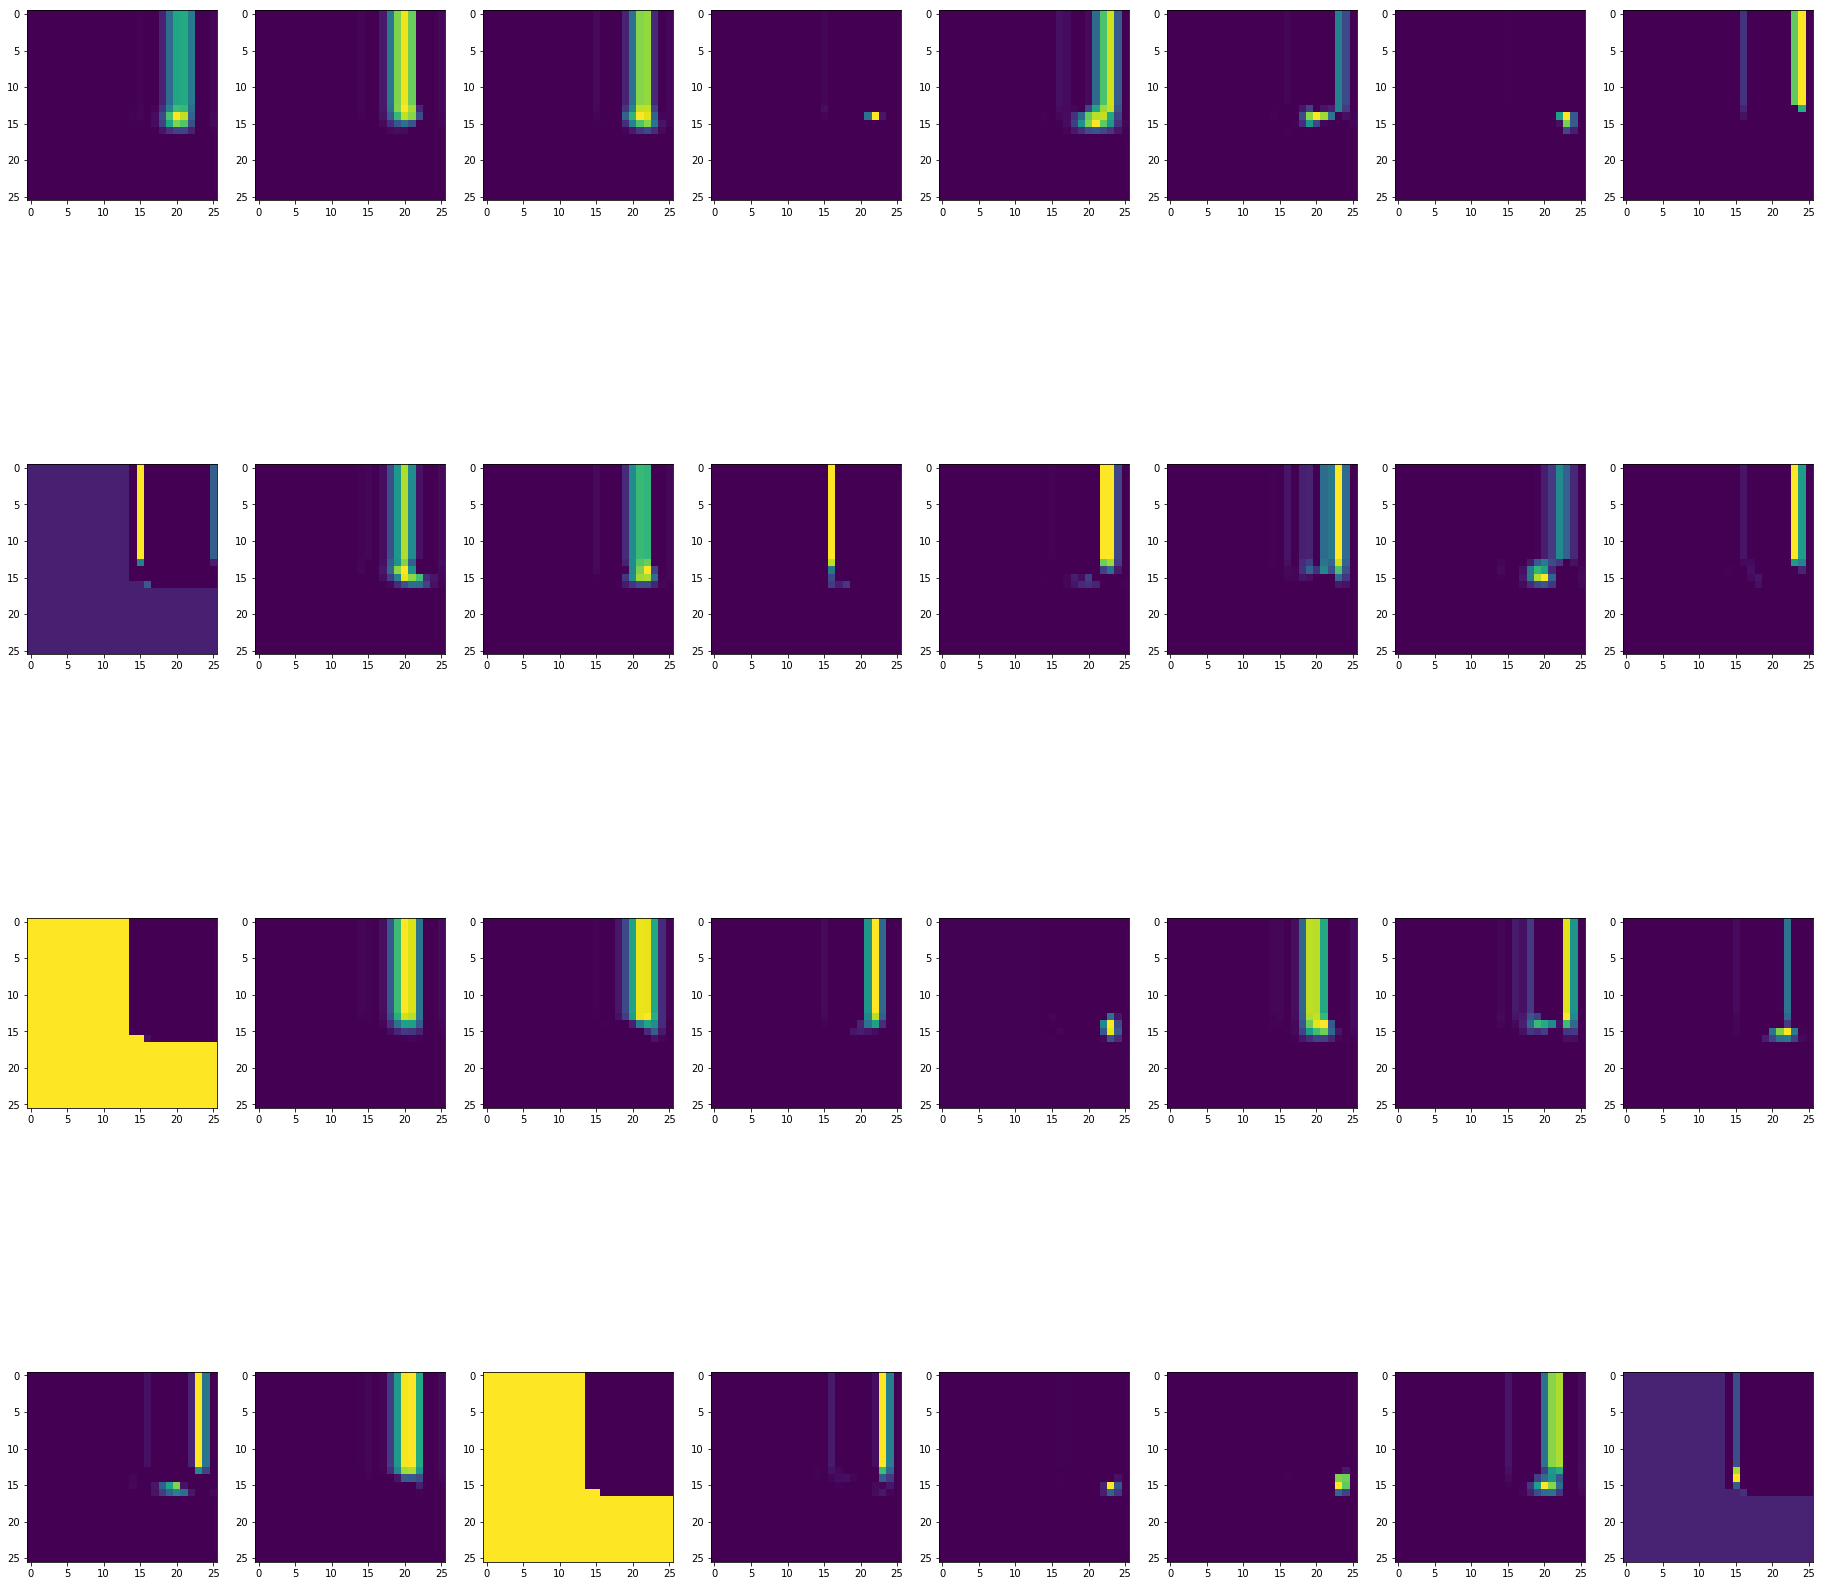

In [14]:
getNsave('conv3x3_hl1',model,x)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     (None, 28, 28, 3)         0         
_________________________________________________________________
conv3x3_hl1 (Conv2D)         (None, 26, 26, 32)        896       
_________________________________________________________________
BatchNormalization_hl2 (Batc (None, 26, 26, 32)        128       
_________________________________________________________________
MaxPooling2D_hl3 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv3x3_hl4 (Conv2D)         (None, 11, 11, 32)        9248      
Total params: 10,272
Trainable params: 10,208
Non-trainable params: 64
_________________________________________________________________
------------ 0 ------------


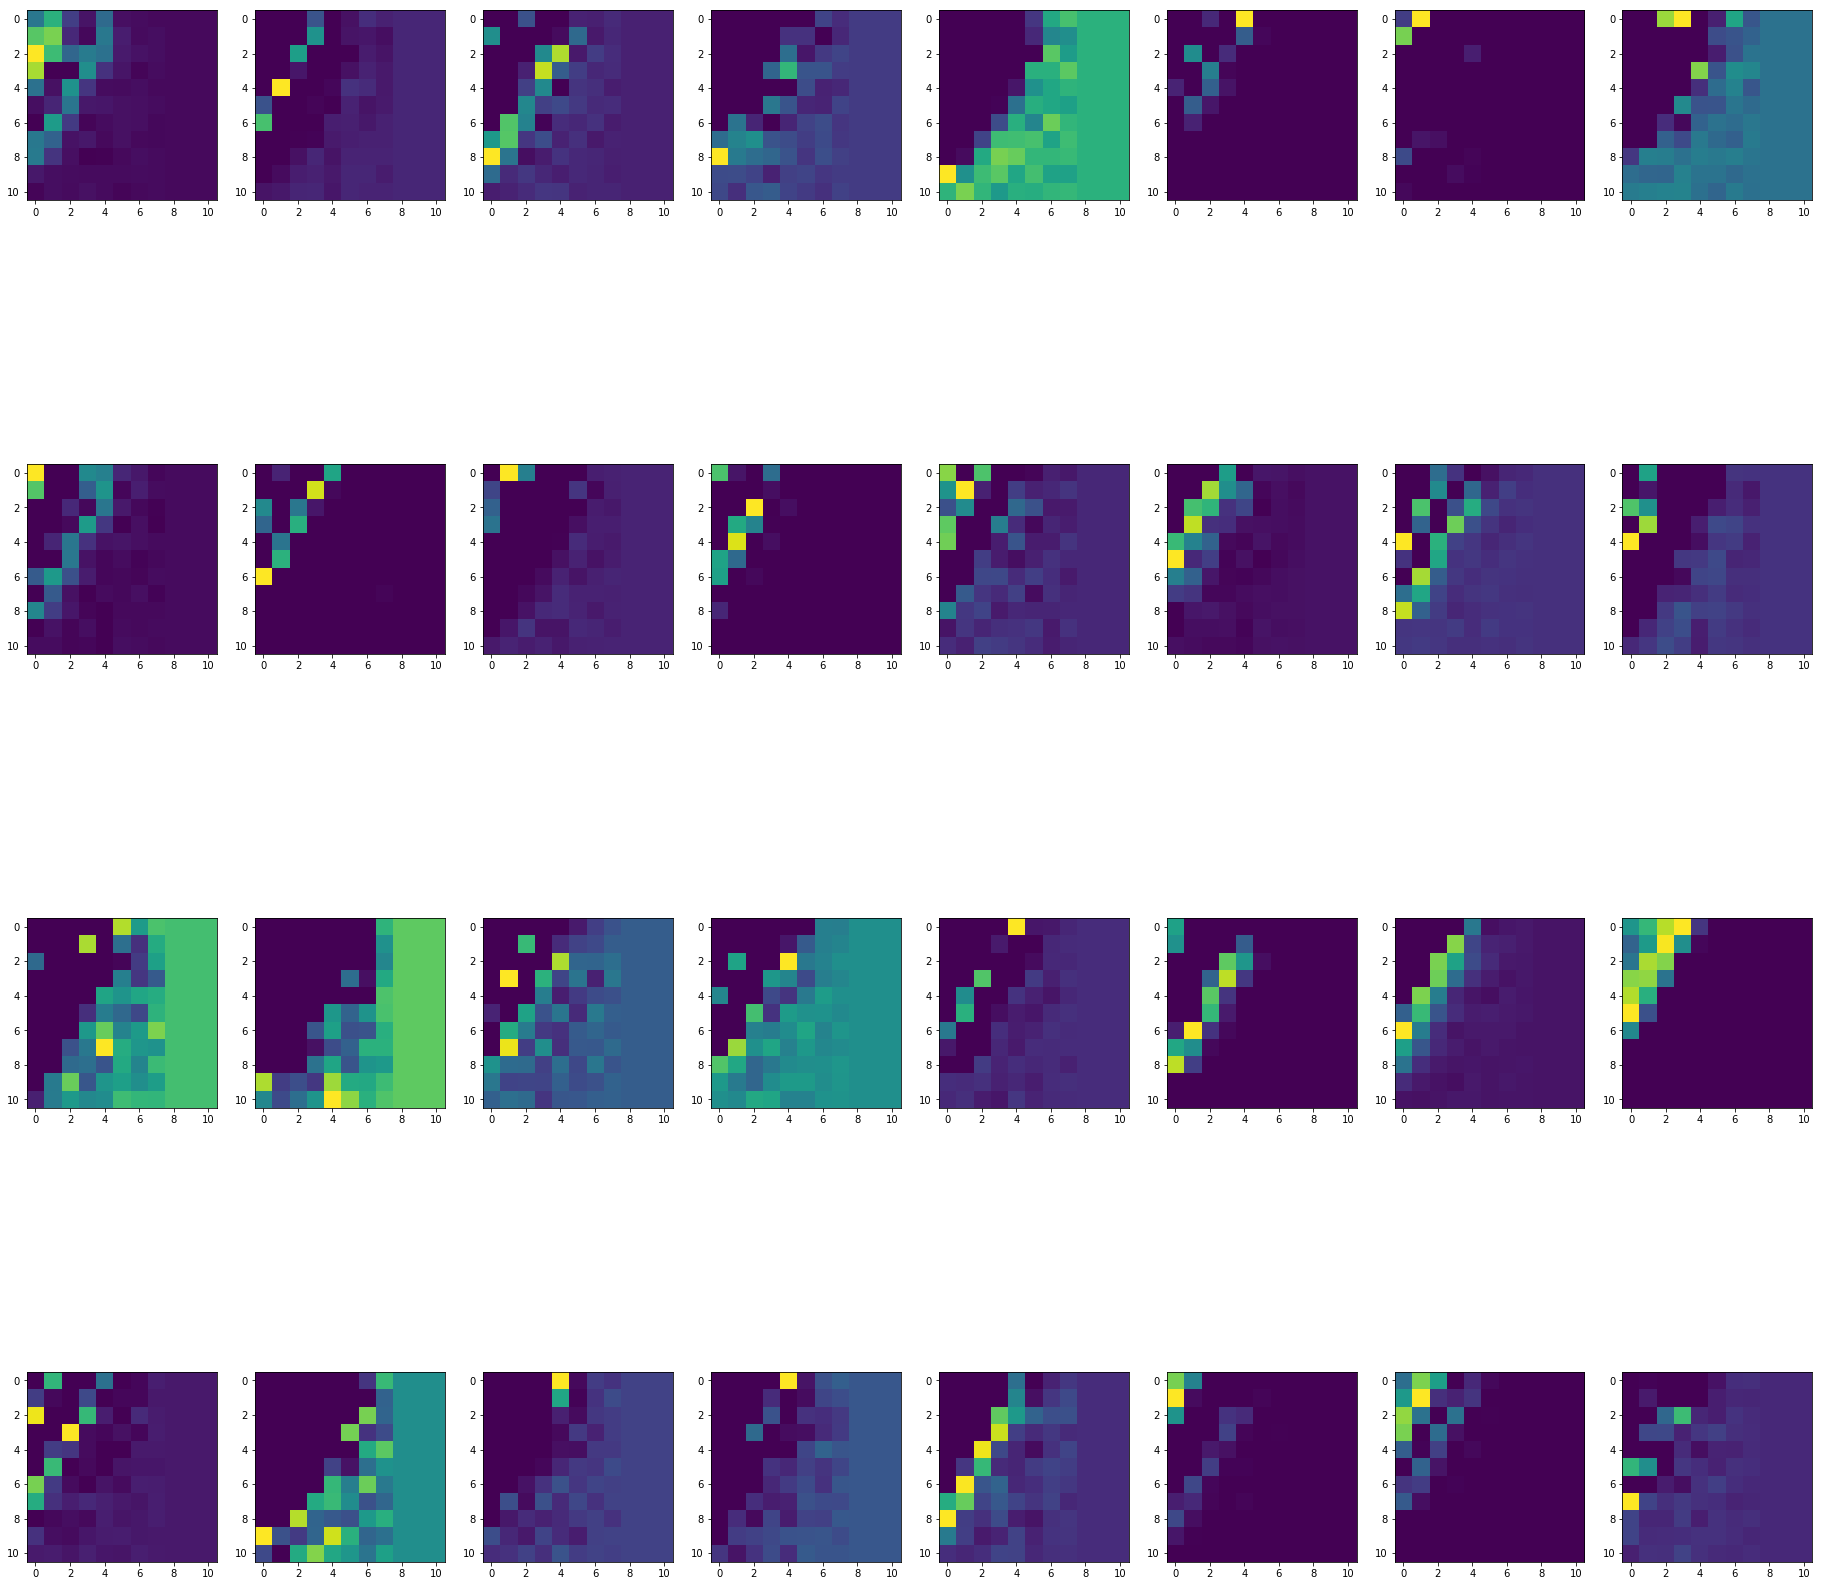

------------ 1 ------------


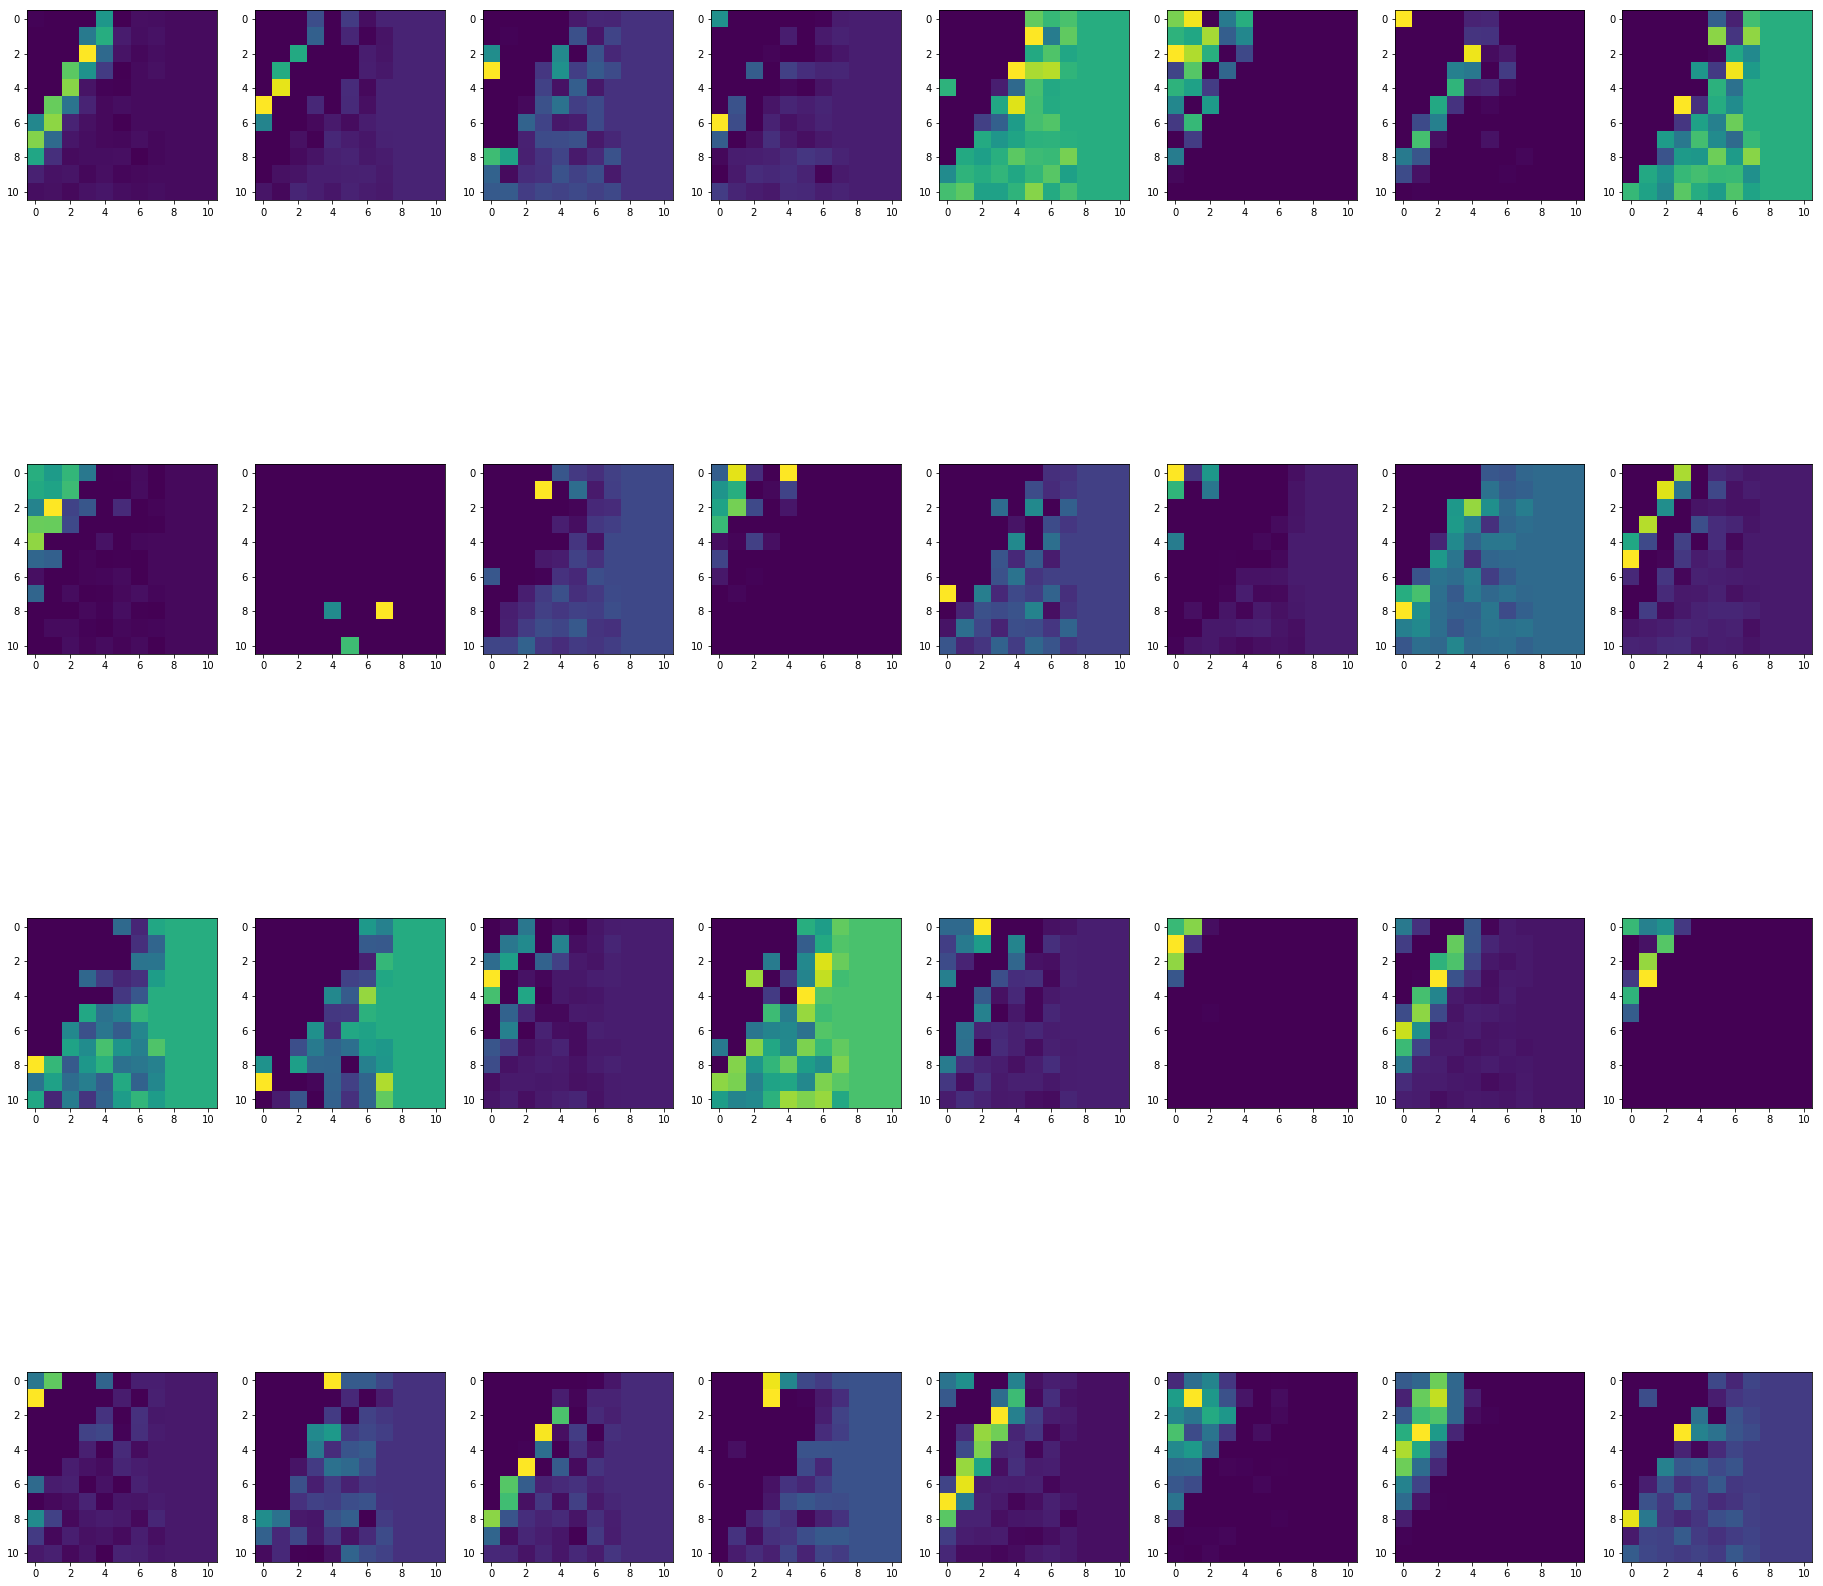

------------ 2 ------------


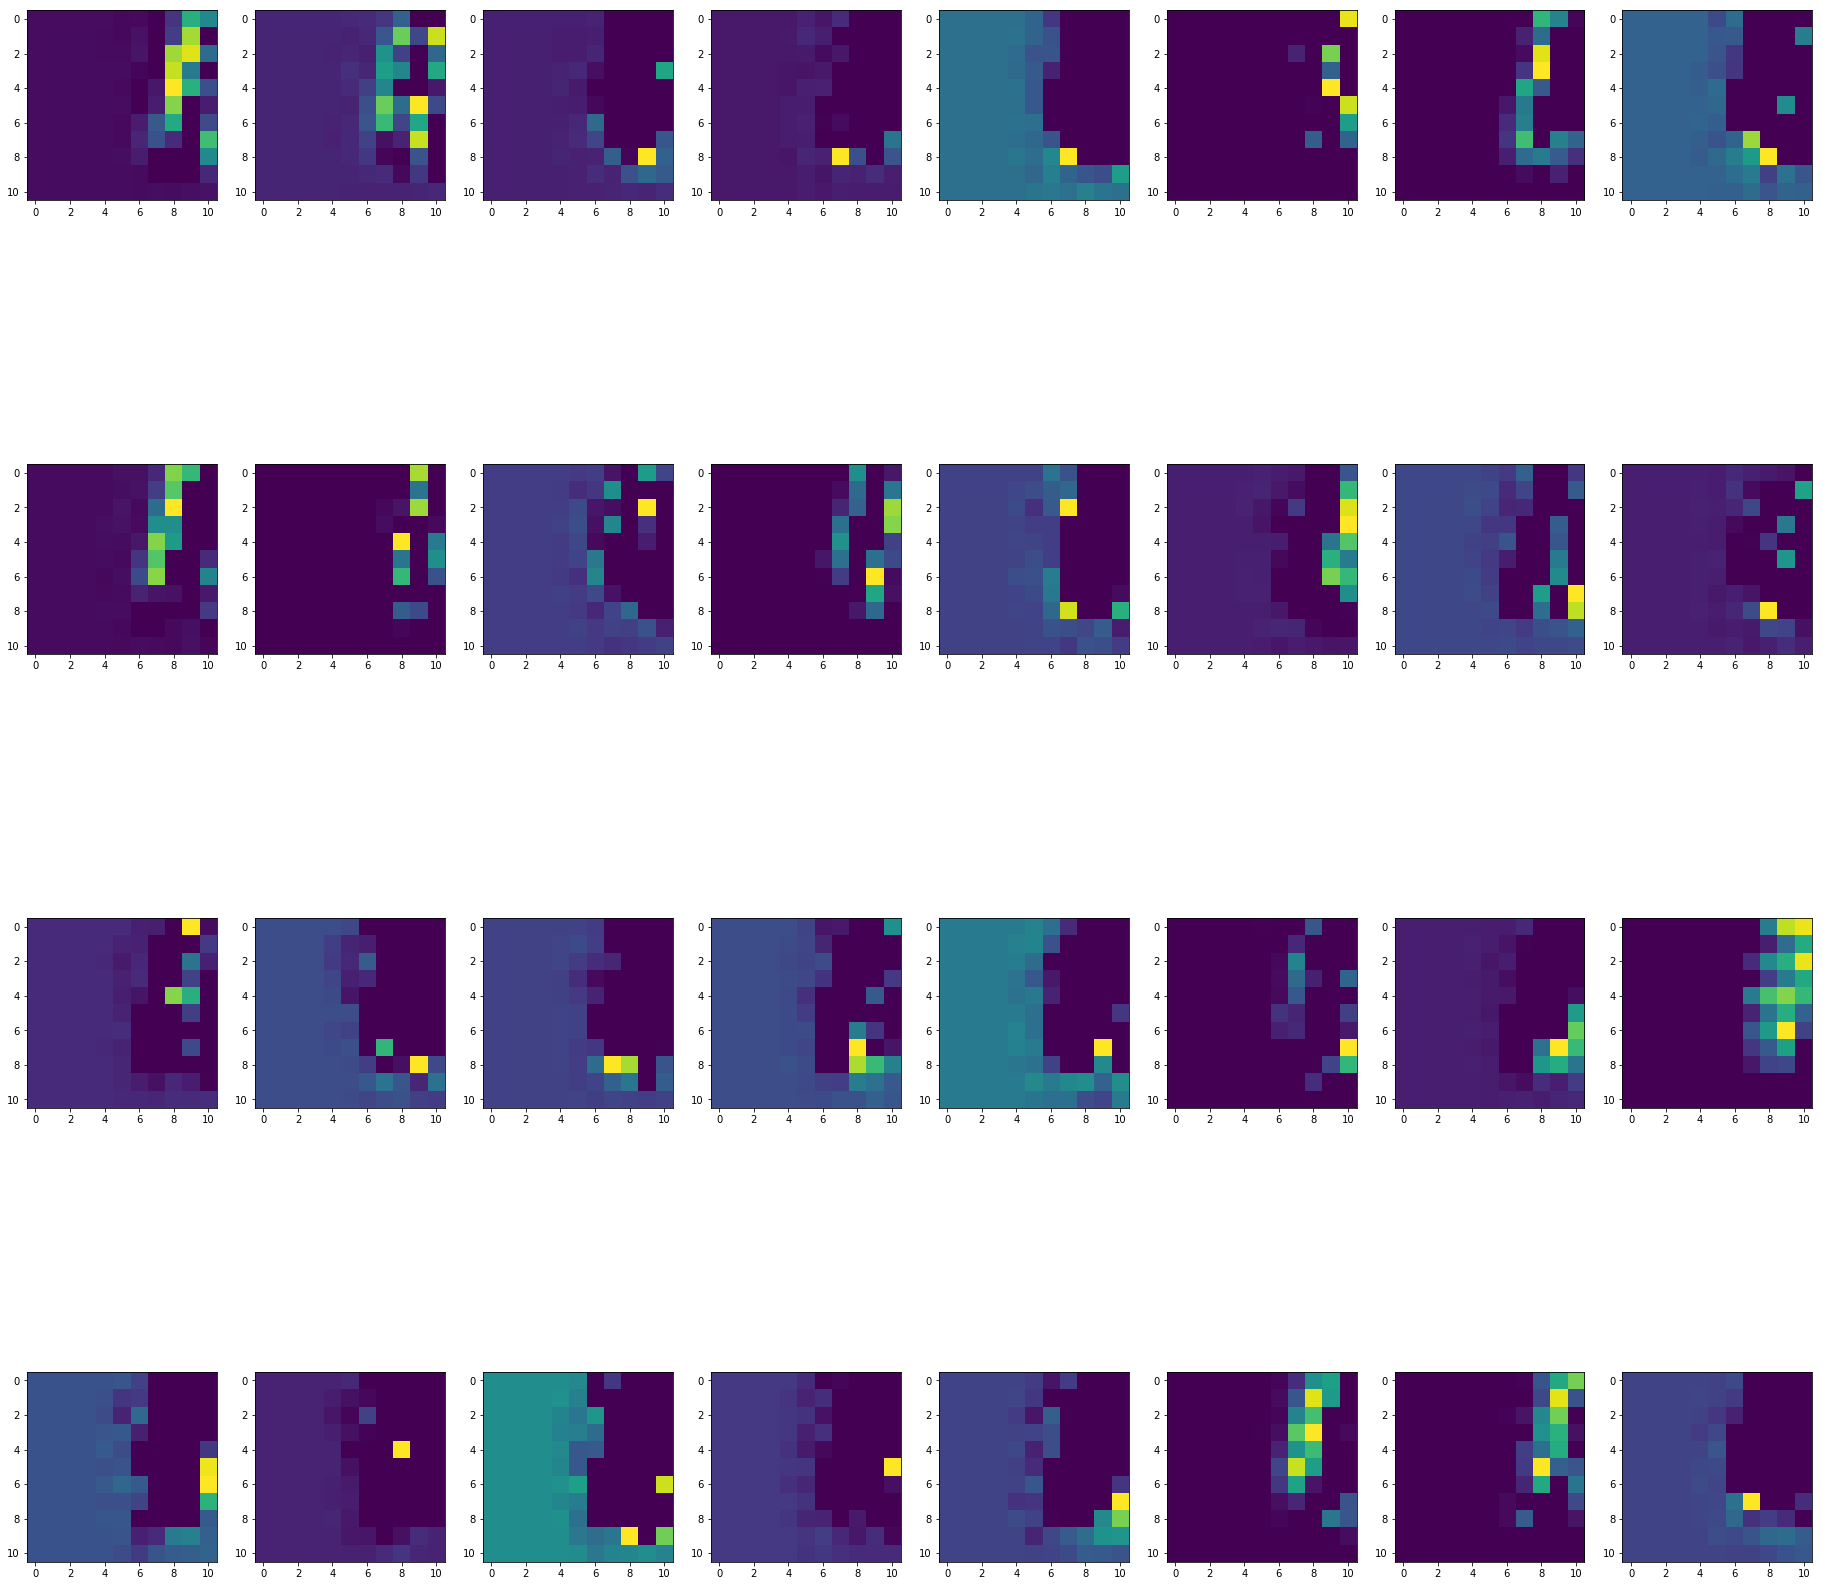

------------ 3 ------------


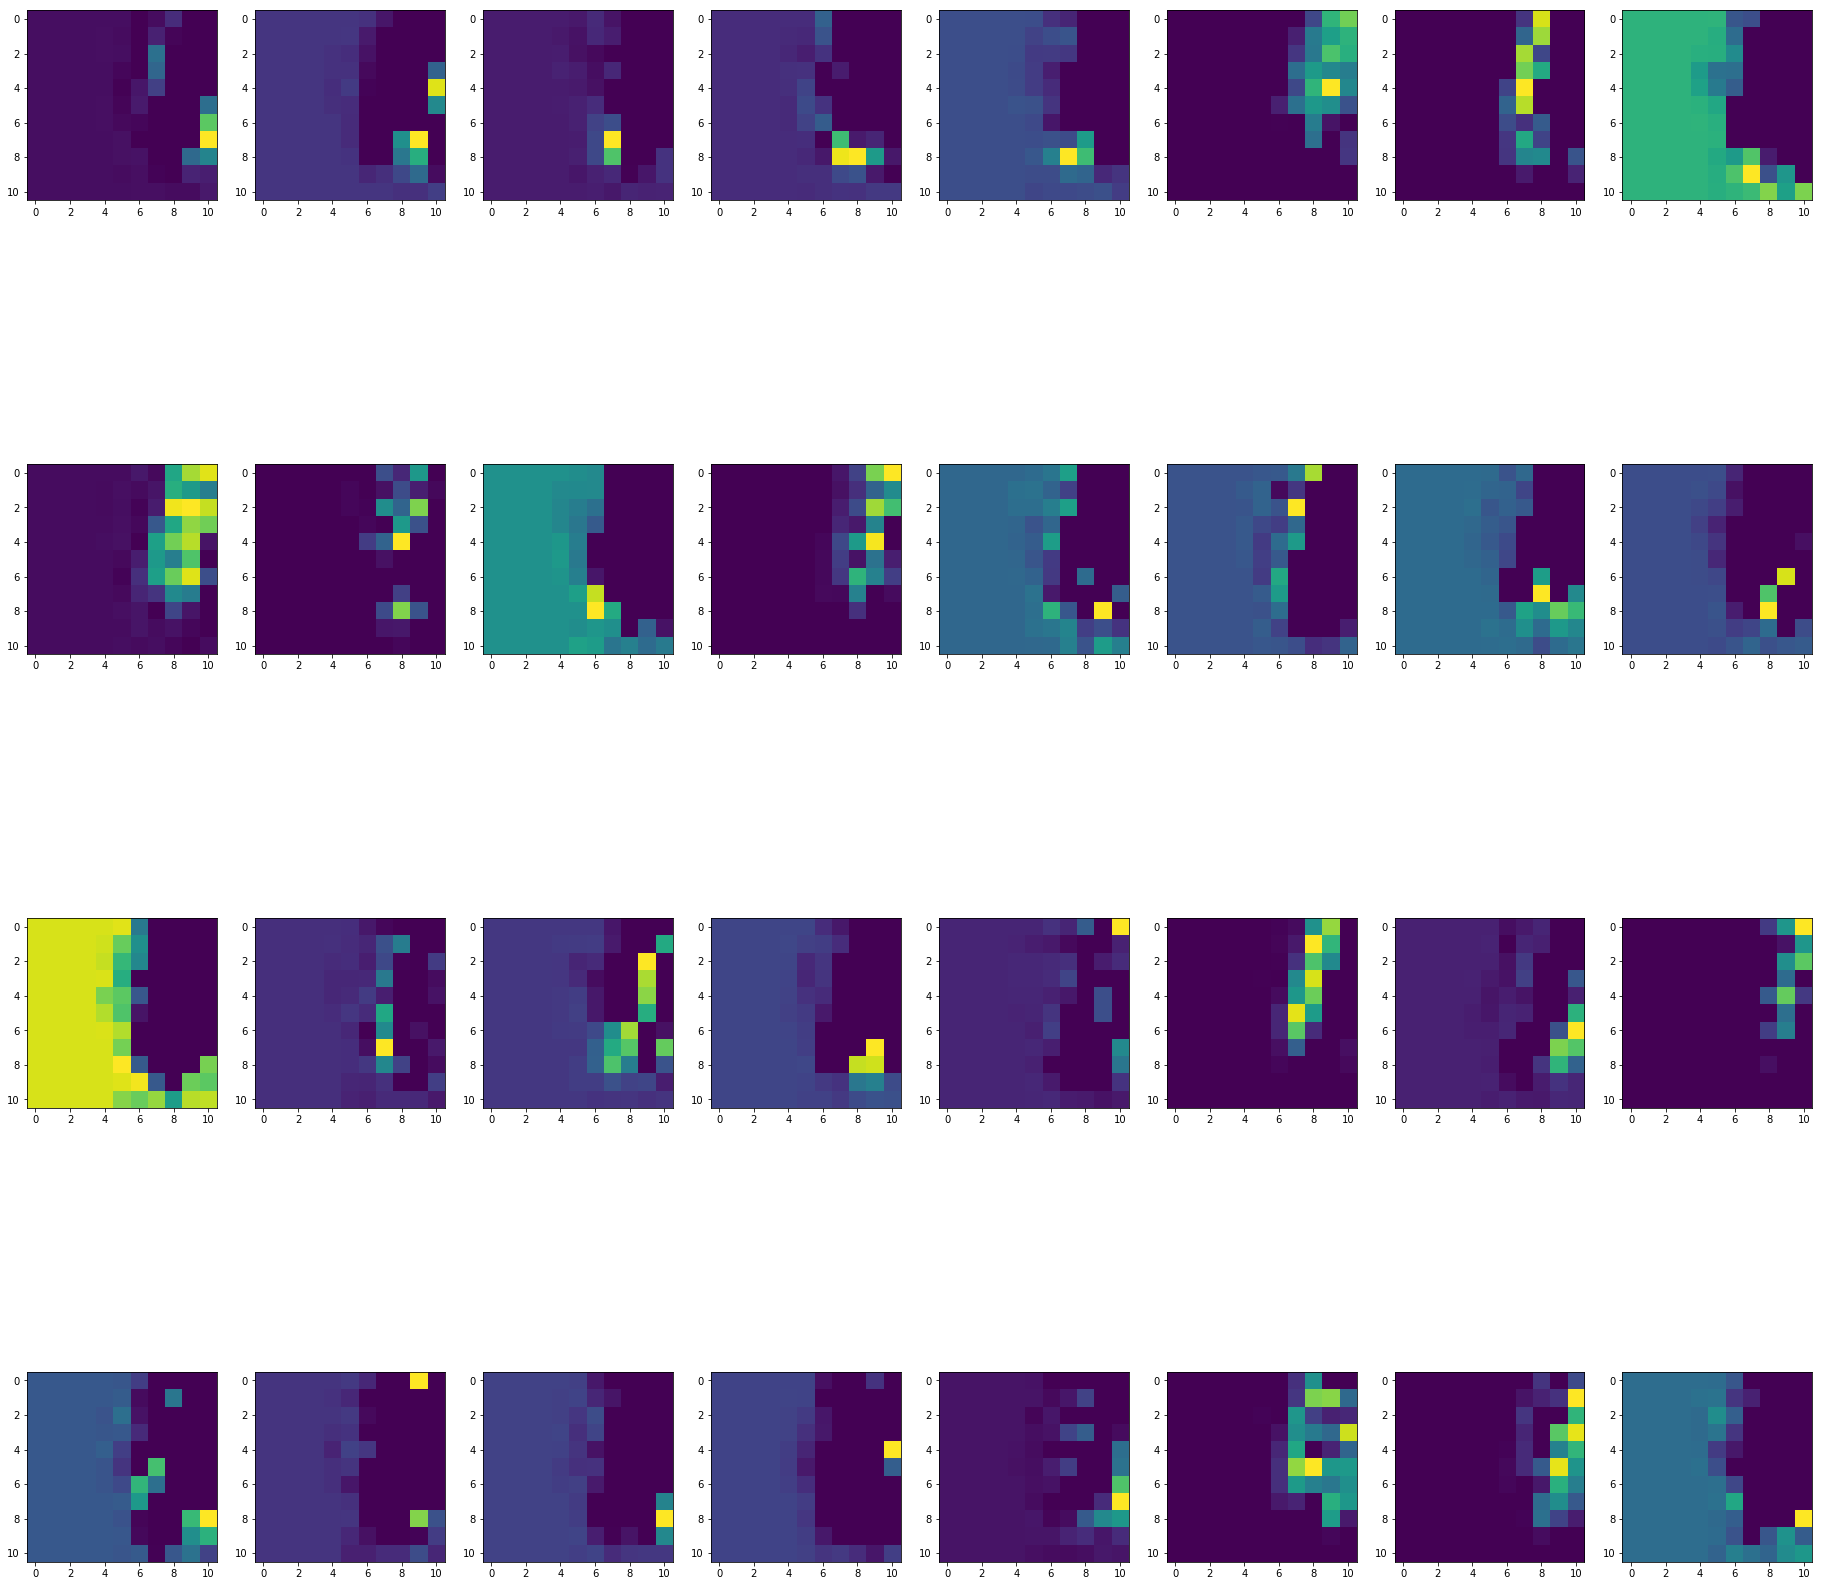

------------ 4 ------------


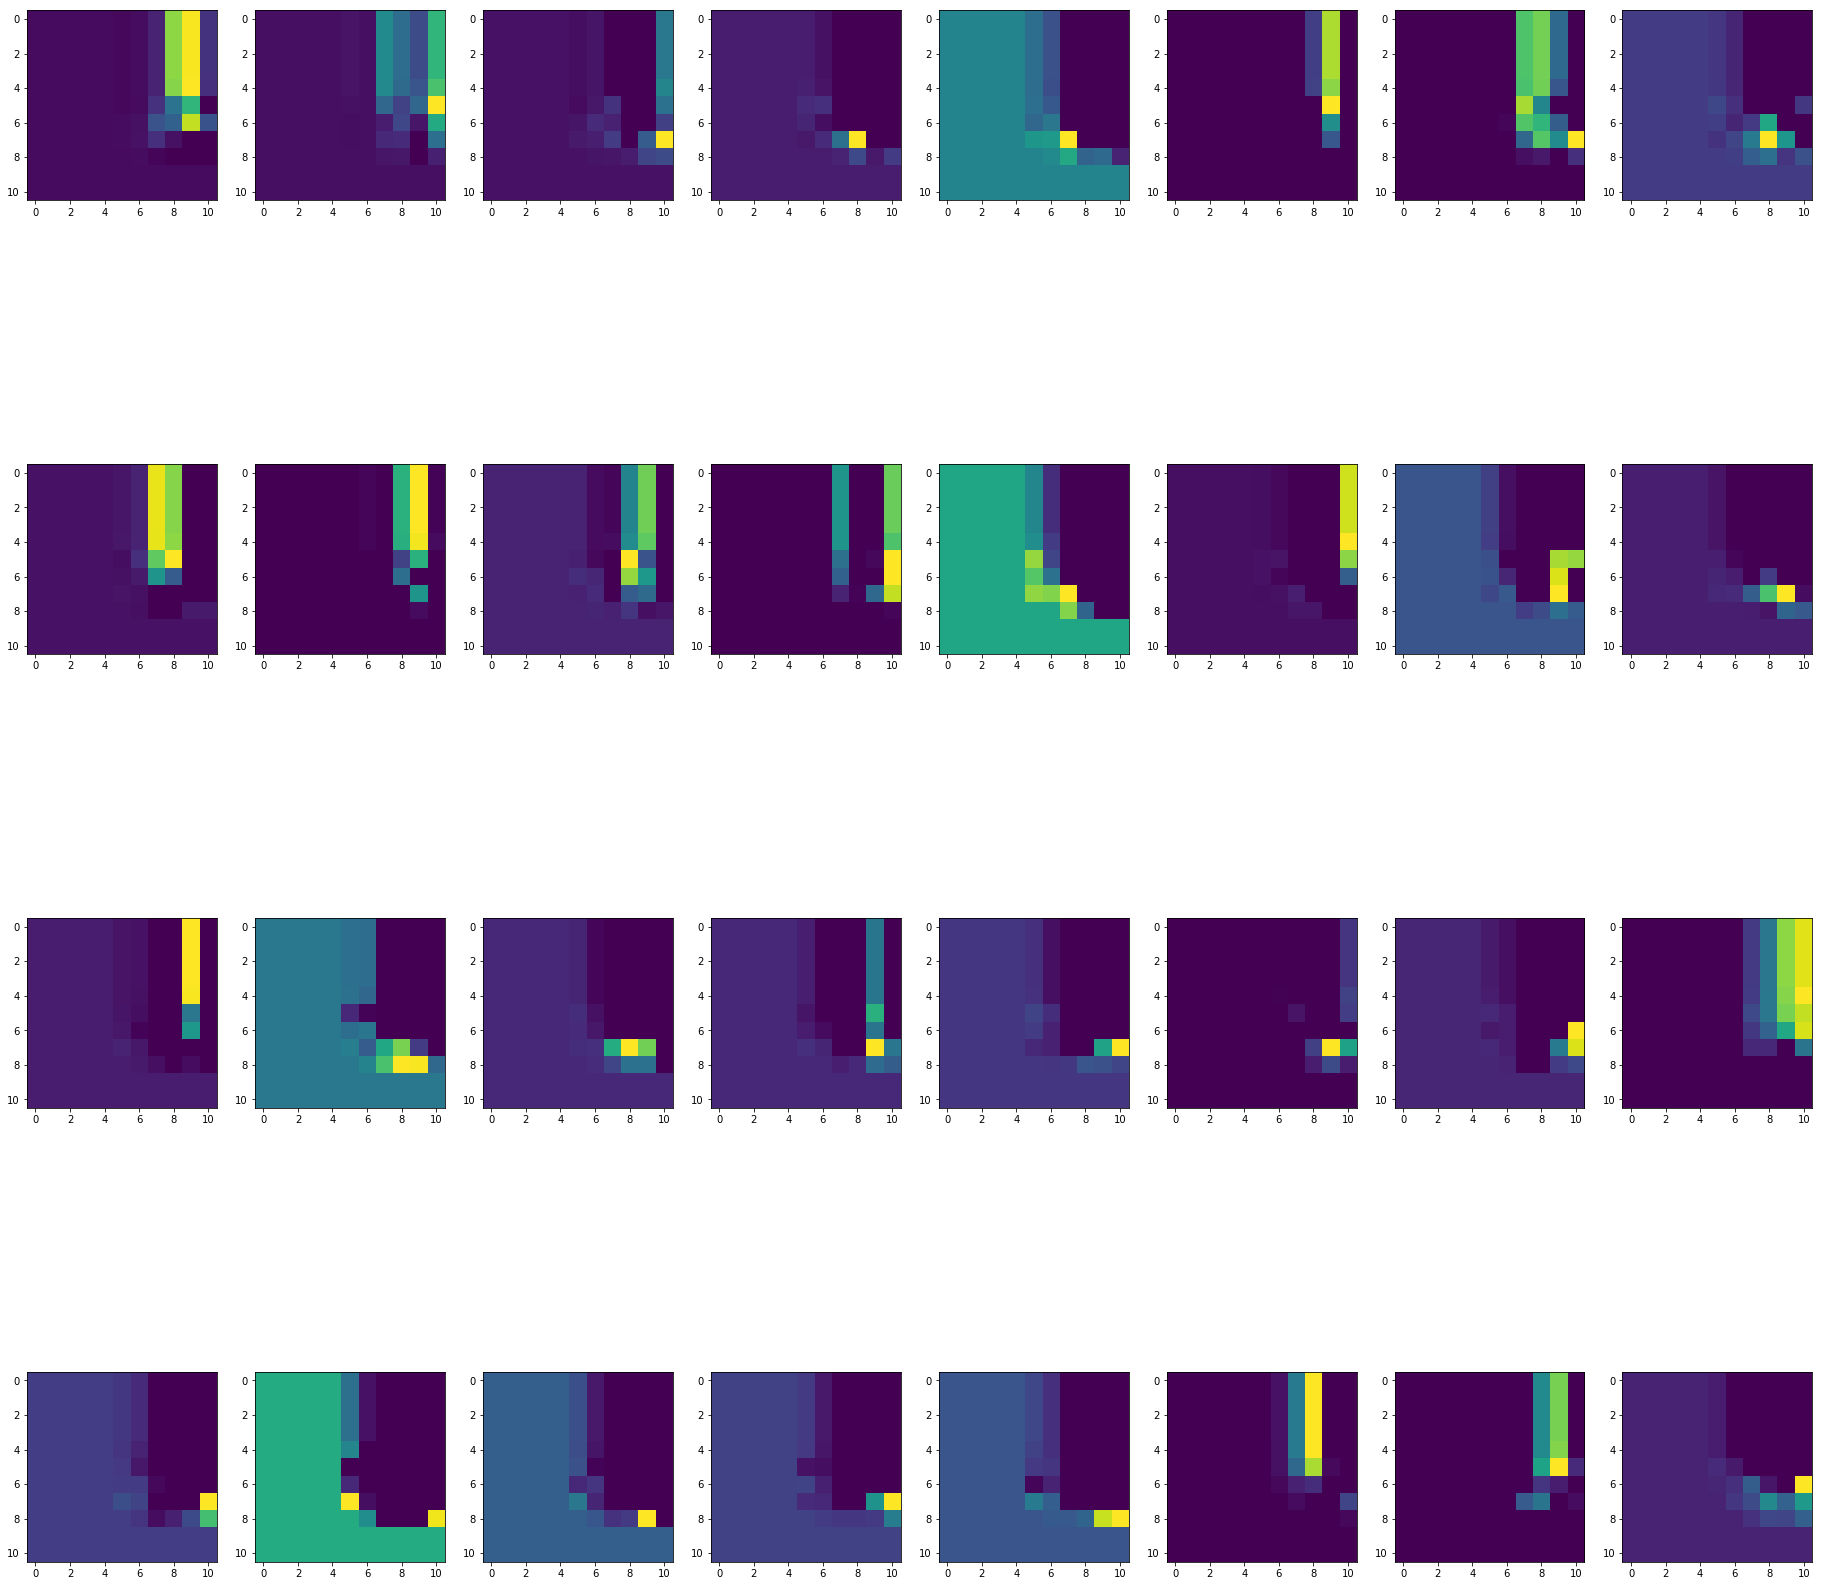

------------ 5 ------------


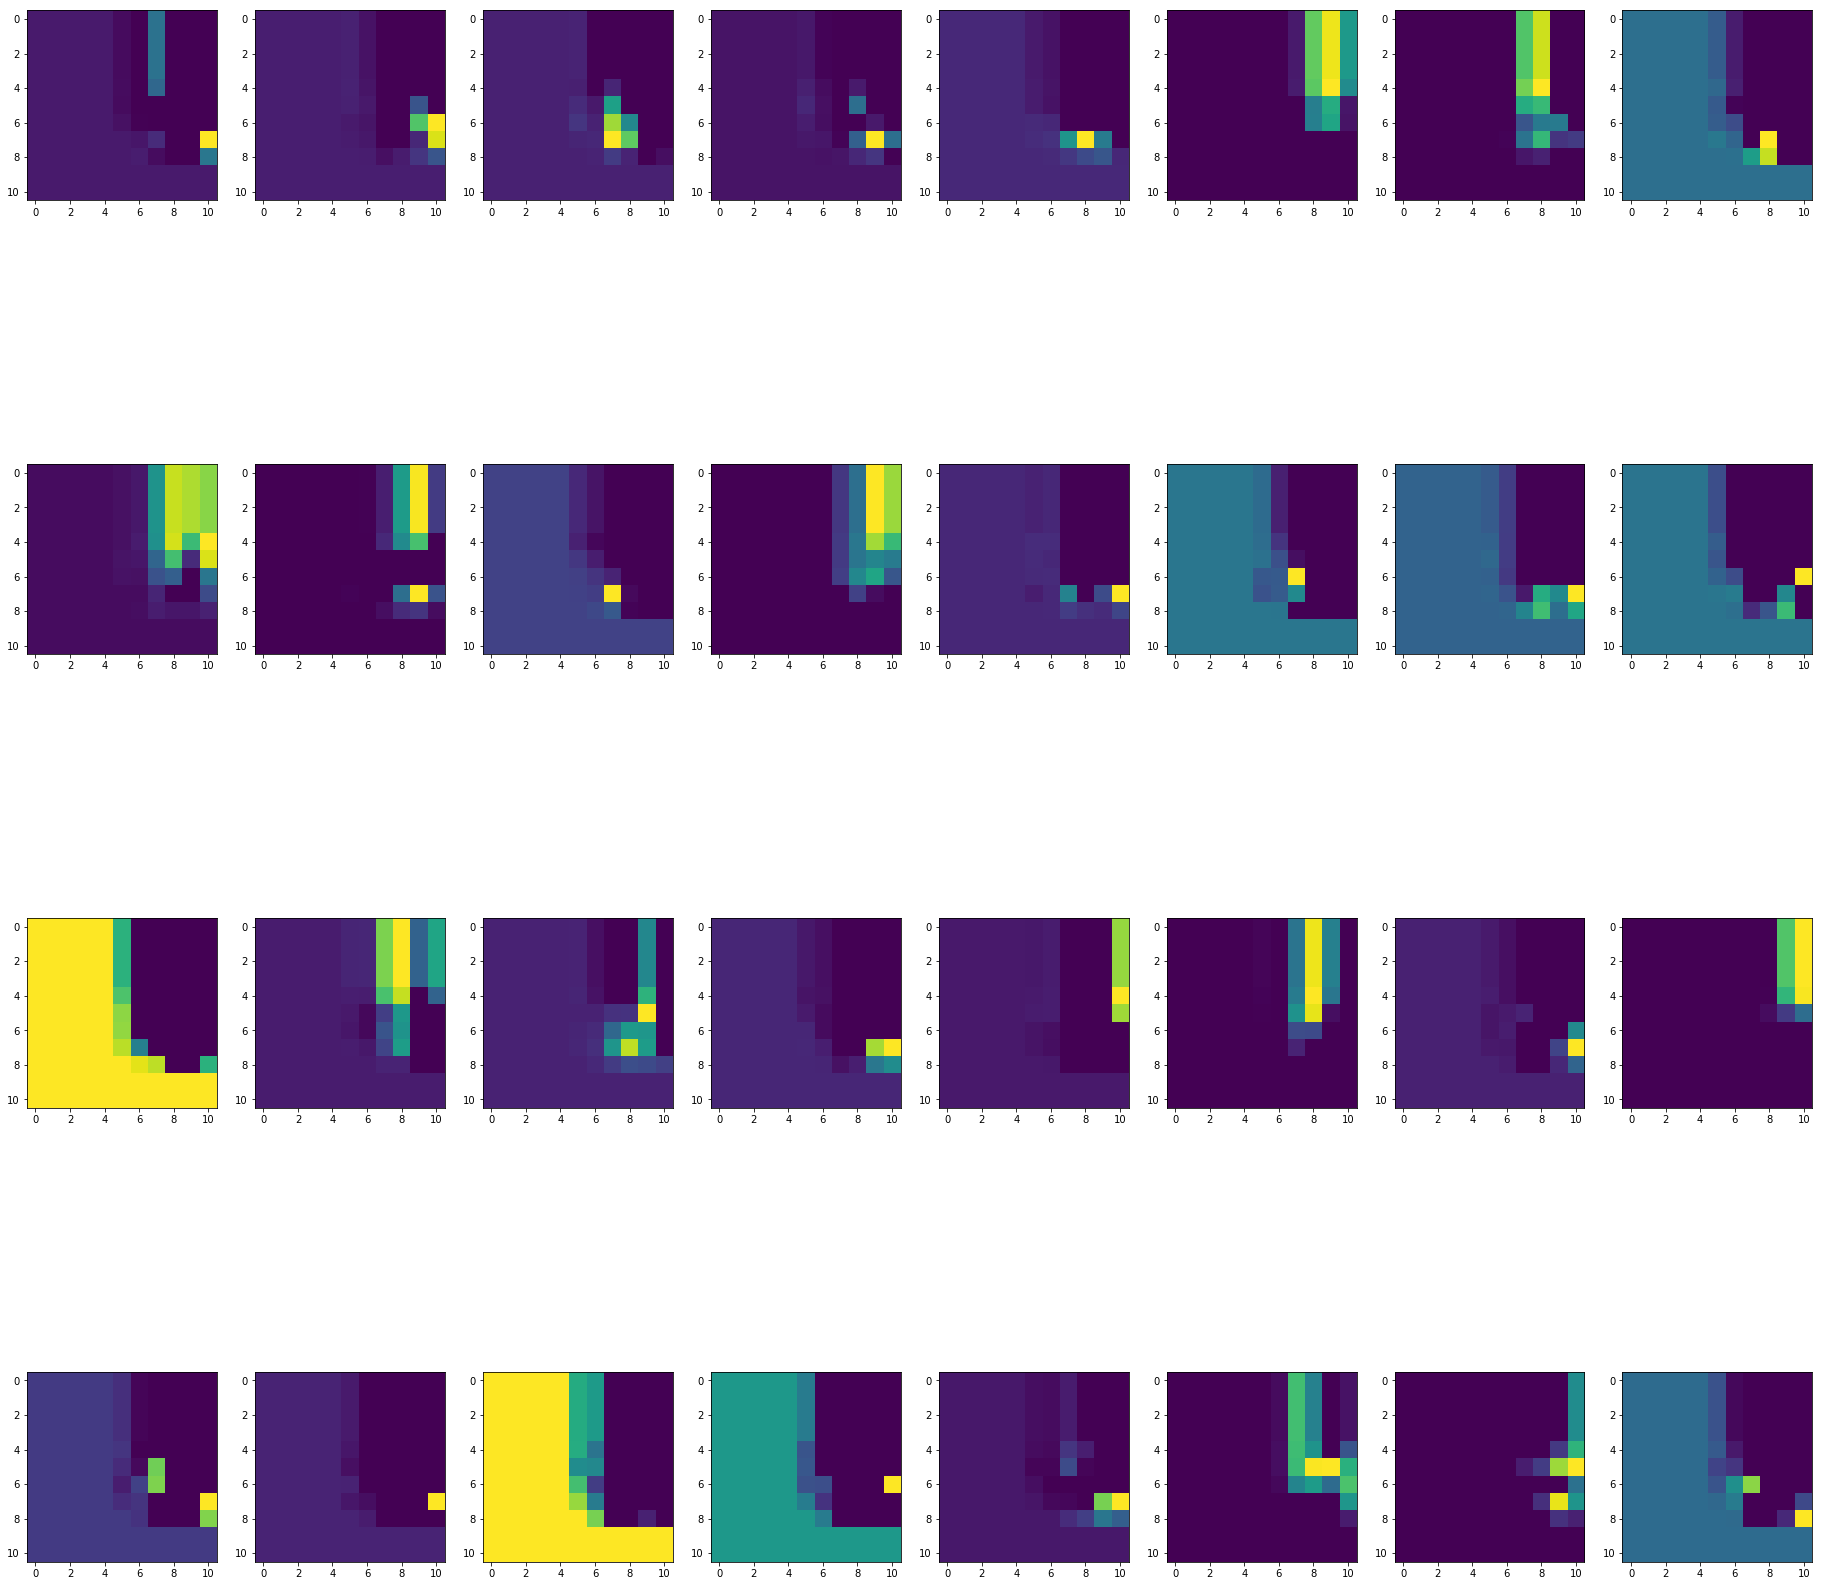

In [15]:
getNsave('conv3x3_hl4',model,x)

In [16]:
def plot_conv_weights(model, layer_name,depth,filters):
    weights = model.get_layer(name=layer_name).get_weights()[0]
    if len(weights.shape) == 4:
        weights = np.squeeze(weights)
        print(weights.shape)
        
        fig, axs = plt.subplots(filters,depth, figsize=(depth*2,filters*2))
#         fig.subplots_adjust(hspace = 2, wspace=2)
        axs = axs.ravel()
        for j in range(depth):
            for i in range(filters):
                axs[32*j+i].imshow(weights[:,:,j,i])
                axs[32*j+i].set_title(str(i))

(3, 3, 3, 32)


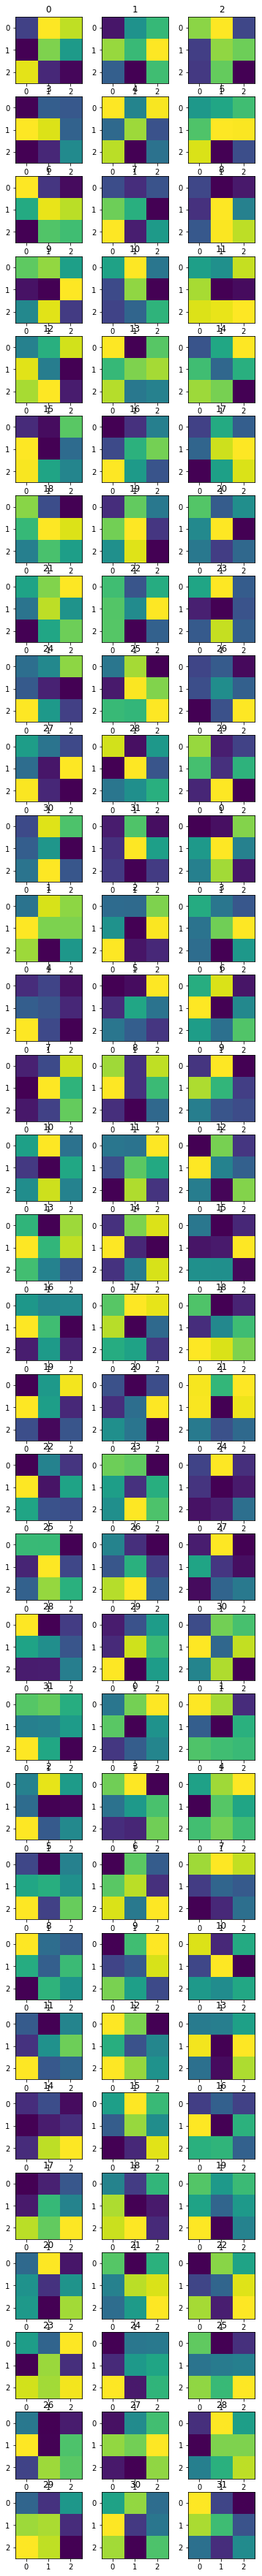

In [17]:
plot_conv_weights(model,'conv3x3_hl1',3,32)

(3, 3, 32, 32)


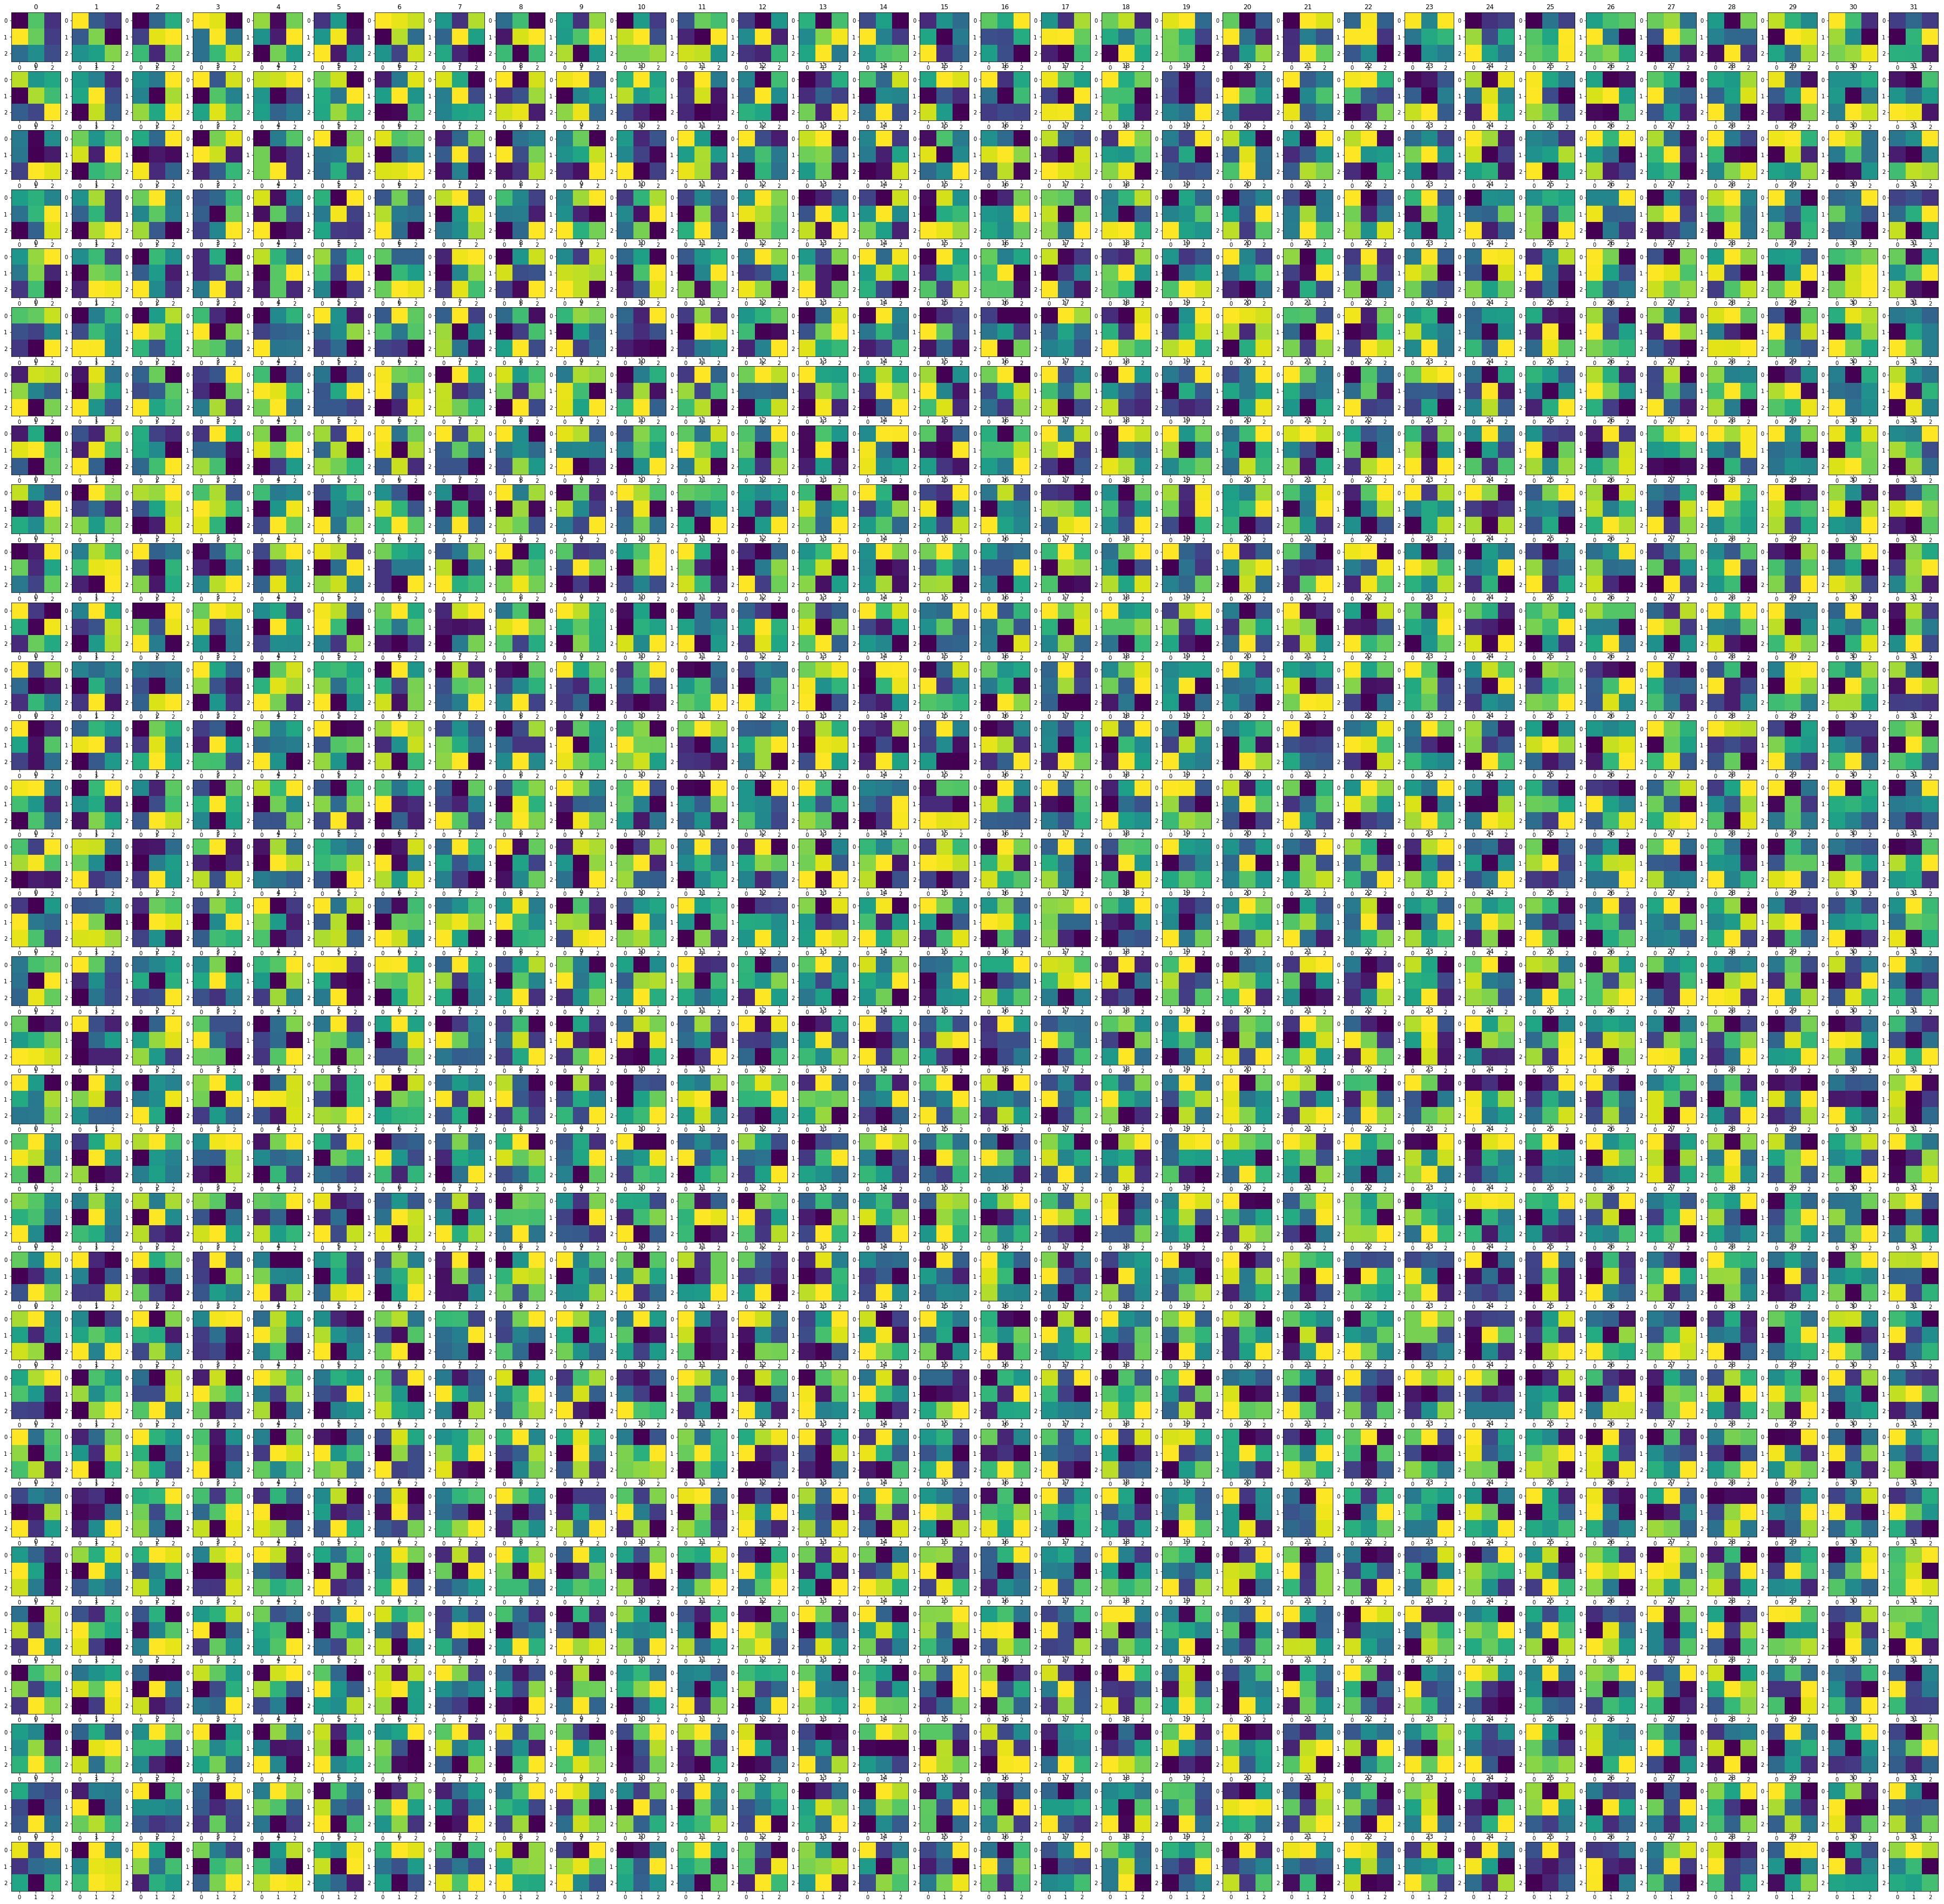

In [18]:
plot_conv_weights(model,'conv3x3_hl4',32,32)

In [19]:
# model.summary()

In [20]:
# model.output[2][1]

In [21]:
#Class activation maps
def cam(model,x,i1,i2=None):
    if i2:
        head_output = model.output[i1][i2]
        print('i2 detected: ',i2)
    else:
        head_output = model.output[i1]
    last_conv_layer = model.get_layer('conv3x3_hl4')

    grads = K.gradients(head_output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([x])

    for i in range(32):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
#     plt.savefig('heatmap.png')

    #Using cv2 to superimpose the heatmap on original image to clearly illustrate activated portion of image
    img = X[2041]


    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * 0.4 + img
    cv2.imwrite('image_name.jpg', superimposed_img)
    print(superimposed_img.shape)
    #2048 is the number of filters/channels in 'mixed10' layer


In [24]:
model=keras.models.load_model('task2.h5')

In [25]:
cam(model,x,1)#give respective head and class(in case of angle)

(28, 28, 3)


f:\python3.6\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


<Figure size 432x288 with 0 Axes>

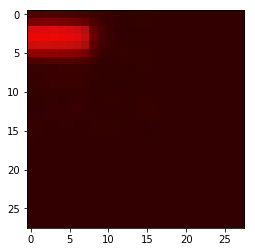

In [26]:
img=cv2.imread('image_name.jpg')
plt.imshow(img)
